## Описание проекта

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

**Наша задача** - построить модель, которая умеет определять рыночную стоимость автомобиля на вторичном рынке.  Для каждого автомобиля требуется предсказать числовое значение стоимости продажи.

В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

**Ход исследования:**

Данные для исследования мы получим из файлов, предоставленных заказчиком.

**Данные**   
train.csv - информация о характеристиках автомобилей, которые будут использоваться в качестве обучающих данных.   
test.csv - информация о характеристиках автомобилей, которые будут использоваться в качестве тестовых данных.    
vin - идентификатор автомобиля в тестовом наборе.   
sellingprice - Целевой признак.   

Наша задача - предсказать значение 'sellingprice' для каждого автомобиля из этого датасета.

**Описание полей данных**

Date: Год выпуска автомобиля.   
Make: Марка автомобиля.   
Model: издание автомобиля определенной марки.   
Trim: Уровни отделки салона автомобиля — это просто разные версии модели.   
Body: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.   
Transmission: механизм, который передает мощность от двигателя к колесам.   
VIN: идентификационный номер транспортного средства.   
State: состояние, в котором автомобиль выставлен на аукцион.   
Condition: Состояние автомобилей на момент аукциона.     
Odometer: расстояние, пройденное автомобилем с момента выпуска.   
Color: Цвет кузова автомобиля.   
Interior: Цвет салона автомобиля.   
Seller: Продавец автомобиля, автосалоны.   
mmr: Рекорд рынка Manhiem, рыночная оценочная цена автомобилей.   
saledate: Дата продажи автомобиля.    

Целевой признак:

sellingprice: цена, по которой автомобиль был продан на аукционе.   

**Исследование пройдет в 7 этапов:**

* загрузка и первичное ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
разработка новых синтетических признаков,
проверка на мультиколлинеарность,
отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.
* общий вывод

## Загрузка и первичное ознакомление с данными

Импортируем необходимые для анализа данных библиотеки.

Считаем данные из csv-файла в датафрейм и сохраним в переменную data.

In [1]:
# импорт библиотек

#!pip install scikit-learn==1.1.3
#!pip install CatBoost
#!pip install -q phik
#!pip install lightgbm
# установим библиотеку для Vin и получим из нее информацию по марке авто
#!pip install vininfo[cli]
import warnings
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import lightgbm
import shap

from phik.report import plot_correlation_matrix
from phik import report

from sklearn import tree

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso
    
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, make_scorer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import (
    cross_validate,
    cross_val_score,
    GridSearchCV,
    train_test_split,
    KFold
)

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from sklearn.compose import make_column_transformer

from vininfo import Vin
from catboost import CatBoostRegressor, cv
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
!pipreqsnb . --force

"pipreqsnb" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

### Первичный обзор данных

In [4]:
data = pd.read_csv('train.csv')

In [5]:
test = pd.read_csv('test.csv')

In [6]:
# выберем стиль для оформления графиков
plt.style.use('fivethirtyeight')

In [7]:
print(f'Исходный датасет')
print(f'Количество строк {data.shape[0]}')
print(f'Количество столбцов {data.shape[1]}')

Исходный датасет
Количество строк 440236
Количество столбцов 15


In [8]:
print(f'Тестовый датасет')
print(f'Количество строк {test.shape[0]}')
print(f'Количество столбцов {test.shape[1]}')

Тестовый датасет
Количество строк 110058
Количество столбцов 14


In [9]:
# напишем функцию для вывода основной информации о датасете
def main_info(data):
    print(f'Выведем первые 5 строк датафрейма')
    display(data.head())
    print()

    print(f'Основная информация о датафрейме')
    print()
    display(data.info())
    print()

    print(f'Числовое описание данных')
    display(data.describe().style.background_gradient())
    print()

    print(f'Количество строк-дубликатов')
    display(data.duplicated().sum())
    print()

    print(f'Количество пропусков в процентном соотношении')
    display(pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient())
    print()

    print(f'Тип признаков')
    print(data.dtypes)

In [10]:
# посмотрим обучающий датасет
main_info(data)

Выведем первые 5 строк датафрейма


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)



Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


None


Числовое описание данных


,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000



Количество строк-дубликатов


0


Количество пропусков в процентном соотношении


,0
year,0.000000
make,1.800000
model,1.800000
trim,1.900000
body,2.400000
transmission,11.700000
vin,0.000000
state,0.000000
condition,2.100000
odometer,0.000000



Тип признаков
year              int64
make             object
model            object
trim             object
body             object
transmission     object
vin              object
state            object
condition       float64
odometer        float64
color            object
interior         object
seller           object
sellingprice      int64
saledate         object
dtype: object


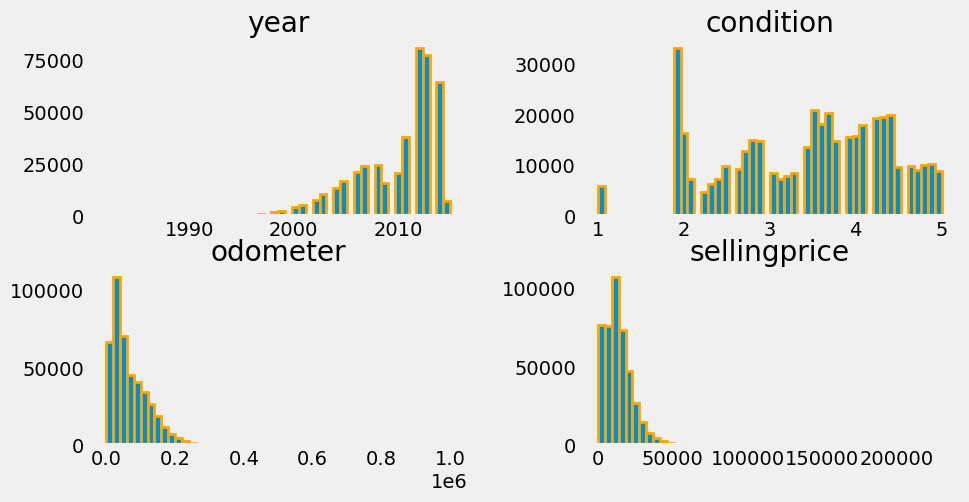

In [11]:
data.hist(bins=50, figsize=(10,5), edgecolor='orange', grid=False, linewidth=2)
plt.show()

In [12]:
# изучим тестовые данные
main_info(test)

Выведем первые 5 строк датафрейма


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)



Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


None


Числовое описание данных


,year,condition,odometer
count,110058.000000,107679.000000,110039.000000
mean,2010.060005,3.423222,68074.331601
std,3.960190,0.951301,53520.988173
min,1982.000000,1.000000,1.000000
25%,2007.000000,2.700000,28313.500000
50%,2012.000000,3.600000,51922.000000
75%,2013.000000,4.200000,98852.500000
max,2015.000000,5.000000,999999.000000



Количество строк-дубликатов


0


Количество пропусков в процентном соотношении


,0
year,0.000000
make,1.900000
model,1.900000
trim,1.900000
body,2.400000
transmission,11.800000
vin,0.000000
state,0.000000
condition,2.200000
odometer,0.000000



Тип признаков
year              int64
make             object
model            object
trim             object
body             object
transmission     object
vin              object
state            object
condition       float64
odometer        float64
color            object
interior         object
seller           object
saledate         object
dtype: object


In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
year,440236.0,2010.040101,3.977945,1982.0,2007.0,2012.0,2013.0,2015.0
condition,430831.0,3.425077,0.949973,1.0,2.7,3.6,4.2,5.0
odometer,440167.0,68344.421604,53542.203908,1.0,28258.0,52098.0,99272.0,999999.0
sellingprice,440236.0,13592.209588,9751.479098,1.0,6900.0,12100.0,18200.0,230000.0


Годы выпуска автомобилей находятся в промежутке с 1982 по 2015 гг.    
Состояние авто оценивается в среднем на 3,4. Максимальная оценка 5.   
Средний пробег автомобилей составляет 68344,42 км. При этом максимальный пробег 999999,0 км.   
Средняя цена продажи составила 13592 ед. При этом максимум составил 230000,0 ед.   

**Вывод после первичного обзора и загрузки обучающих и тестовых данных:**

* обучающий датасет содержит 440236 объектов и 15 столбцов(признаков);   
* названия колонок почти соответствуют первоначальному описанию данных (столбец date назван уеаг, столбец mmr отсутствует);   
* типы данных: 4 столбцов это численные признаки (int64,float64) и 11 столбцов это категориальные(object);   
* в данных обнаружены пропуски:11.7% столбец transmission, 2.4% - body, 2.1% - condition, и около 1.8-1.9% -   make,model,trim(обработаем позднее);   
* строки с явными дубликатами отсутствуют;      
* из описания данных видно, что все столбцы достаточно информативны и будут полезны для предсказания стоимости;

* целевой признак в столбце sellingprice.

В некоторых столбцах трейна (например,saledate) требуется поменять тип данных, а также в тесте в столбцах condition и    odometer (с float64 на float).



В тестовых данных мы имеем 110058 объектов и 14 столбцов(отсутствует целевой признак, который будем предсказывать). В остальном те же характеристики, что и в обучающем наборе данных.

Перед нами стоит задача регрессии. 

### Проведем более детальную предобработку наших признаков

**Поменяем тип данных в дате продажи**

In [14]:
# переведем столбец к типу данных datetime, с учетом временной зоны мирового стандартного времени UTC
data['saledate'] = pd.to_datetime(data['saledate'],utc=True)

data['saledate']

0        2015-06-01 19:30:00+00:00
1        2015-02-24 18:00:00+00:00
2        2015-06-09 19:30:00+00:00
3        2015-06-16 20:00:00+00:00
4        2015-02-02 20:00:00+00:00
                    ...           
440231   2015-01-19 20:30:00+00:00
440232   2015-02-10 18:00:00+00:00
440233   2015-03-02 20:30:00+00:00
440234   2015-01-13 18:05:00+00:00
440235   2015-01-14 18:00:00+00:00
Name: saledate, Length: 440236, dtype: datetime64[ns, UTC]

In [15]:
test['saledate'] = pd.to_datetime(test['saledate'],utc=True)

In [16]:
# посмотрим период за который у нас есть данные в обучающей выборке
max_date = data['saledate'].max()
min_date = data['saledate'].min()
print(f'Обучающие данные представлены за период c {min_date} по {max_date}')

Обучающие данные представлены за период c 2014-01-01 01:15:00+00:00 по 2015-07-20 19:30:00+00:00


In [17]:
# посмотрим период за который у нас есть данные в тестовой выборке
max_tdate = test['saledate'].max()
min_tdate = test['saledate'].min()
print(f'Тестовые данные представлены за период c {min_tdate} по {max_tdate}')

Тестовые данные представлены за период c 2014-01-01 01:15:00+00:00 по 2015-07-13 23:30:00+00:00


In [18]:
# получим информацию о годах продажи
data['saledate'].dt.year.sort_values().unique()

array([2014, 2015], dtype=int64)

In [19]:
# получим информацию о месяцах продажи
data['saledate'].dt.month.sort_values().unique()


array([ 1,  2,  3,  4,  5,  6,  7, 12], dtype=int64)

Нет продаж с августа по декабрь.

In [20]:
# получим информацию о дне недели
data['saledate'].dt.weekday.sort_values().unique()


array([0, 1, 2, 3, 4, 6], dtype=int64)

Машины продавались с понедельника по пятницу и в воскресенье. В субботу продаж не было.

**Проведем работу с пропусками в данных**

In [21]:
# посмотрим подробно пропуски в 'transmission'
data[data['transmission'].isnull()].head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
13,2006,Chevrolet,Silverado 1500,LS,Extended Cab,NaN,1gcek19bx6z269153,tx,2.2,166999.0,white,gray,texas direct auto,6700,2015-02-24 18:20:00+00:00
27,2014,Dodge,Charger,SXT,Sedan,NaN,2c3cdxhg0eh267271,va,4.0,21631.0,blue,black,hertz corporation/gdp,18100,2015-02-11 16:45:00+00:00
31,2012,Mercedes-Benz,GL-Class,GL450 4MATIC,SUV,NaN,4jgbf7be8ca797360,ga,4.1,55612.0,white,brown,mercedes-benz finc wholesale advantage,30750,2015-02-03 18:00:00+00:00
49,2007,Chevrolet,Silverado 1500,LTZ,Crew Cab,NaN,2gcek13m171647736,ga,2.2,108799.0,blue,—,td auto finance,15200,2015-01-08 02:00:00+00:00
53,2013,Ford,Mustang,V6,Convertible,NaN,1zvbp8em0d5237253,pa,3.5,67478.0,blue,black,northeast leasing,11600,2015-03-12 19:00:00+00:00


In [22]:
# посмотрим подробно пропуски в 'transmission' в тесте
test[test['transmission'].isnull()].head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,2015-02-26 17:00:00+00:00
19,2014,Chevrolet,Silverado 1500,LT,crew cab,NaN,3gcukrec4eg454516,pa,4.9,26294.0,red,black,enterprise veh exchange/rental,2015-07-13 23:30:00+00:00
24,2014,Ford,E-Series Wagon,E-350 Super Duty XLT,van,NaN,1fbne3bl1eda46070,ny,3.3,33020.0,white,gray,ford motor credit company,2015-06-02 19:20:00+00:00
53,2013,Honda,CR-V,EX-L,SUV,NaN,5j6rm3h7xdl004568,ga,3.9,30686.0,blue,gray,wells fargo dealer services,2015-01-21 18:00:00+00:00
54,2010,Audi,A6,3.0T Premium quattro,Sedan,NaN,waufgafb8an026867,pa,4.6,74911.0,blue,black,adcock brothers inc,2015-02-20 01:00:00+00:00


In [23]:
# посмотрим подробно пропуски в столбце `make`
data[data['make'].isnull()].head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
10,2007,NaN,NaN,NaN,NaN,automatic,5tfbv54157x019560,ca,3.1,102507.0,blue,gray,aaero sweet company,17250,2015-01-28 19:30:00+00:00
42,2007,NaN,NaN,NaN,NaN,manual,jm1bk34l671745431,md,2.8,92656.0,blue,gray,credit acceptance corp/vrs/southfield,5600,2015-06-15 19:30:00+00:00
63,2011,NaN,NaN,NaN,NaN,automatic,1fdne1bw5bda64735,ga,5.0,67159.0,white,gray,"vpsi, inc",13200,2015-06-03 20:00:00+00:00
64,2008,NaN,NaN,NaN,NaN,automatic,1gbdv13wx8d142776,ca,4.1,113582.0,white,gray,wholesale motor sales inc,4100,2015-02-04 20:00:00+00:00
111,2006,NaN,NaN,NaN,NaN,automatic,3gnda13d36s611801,nv,2.8,129019.0,orange,gray,credit acceptance corp/vrs/southfield,2900,2015-02-04 20:00:00+00:00


In [24]:
# посмотрим подробно пропуски в столбце `make` в тесте
test[test['make'].isnull()].head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
22,2006,NaN,NaN,NaN,NaN,automatic,3gnda23d06s523147,pa,2.4,143377.0,blue,gray,ryan mtrs of morristown inc,2015-01-22 17:00:00+00:00
72,2000,NaN,NaN,NaN,NaN,manual,1j4fa59s0yp723644,mo,NaN,76674.0,black,—,effingham auto care & tire inc,2014-12-22 03:00:00+00:00
220,2003,NaN,NaN,NaN,NaN,automatic,jtjbt20x930014425,tx,4.9,107337.0,silver,gray,fairway ford henderson,2015-02-17 18:00:00+00:00
237,1998,NaN,NaN,NaN,NaN,automatic,1j4gz78yxwc163618,nv,2.0,243163.0,gray,—,titlemax/las vegas nv32,2015-02-18 19:00:00+00:00
287,2009,NaN,NaN,NaN,NaN,automatic,1gbhg39c591143468,pa,2.1,179884.0,white,gray,lease plan usa,2015-02-23 17:30:00+00:00


Пропуски также обнаружены и в соседних с `make` столбцах, таких как `model`,`trim`,`body`.	

<div class="alert alert-warning">
<b>Комментарий ревьювера ⚠️: </b><br>
    Устанавливать библиотеки в рамках тетрадки - считается плохой практикой. Лучше все зависимости указывать в отдельном файле, который обычно называют requirements.txt и если заказчик или коллега захочет воспрозвести исследование он сможет установить все необходимые пакеты используя данный файл с помощью команды <code>!pip install -r requirements.txt</code>.<br>
    <b>Кстати, полезный совет:</b> если создавать requirements через <code>!pip freeze</code>, то получается полный список всех установленных библиотек длиной с экватор, а можно прямо из тетрадки создать список библиотек, которые только в этой тетрадке используются. Для этого есть модуль pipreqsnb: прямо в тетрадке пишем <code>!pipreqsnb . --force</code>😉 Точка - означает, что requirements создается прям здесь рядом с тетрадкой, а force - перезаписать если такой файл уже есть ☝️<br>
    И еще, есть два похожих модуля <code>pipreq</code> и <code>pipreqsnb</code>: первый не указывает стандартные библиотеки типа pandas и numpy, а второй указывает все ☝️
</div>

In [25]:
# напишем функцию для замены пропущенных значений в столбце 'make'
def fill_car_details(row):
    # получим значения VIN из столбца 'vin'
    vin_number = row['vin']

    vin = Vin(vin_number)

    # заполним значений столбцов 'make' из VIN
    row['make'] = vin.manufacturer

    return row

# примененим функцию fill_car_details к каждой строке DataFrame
data = data.apply(fill_car_details, axis=1)

# посмотрим подробно пропуски в столбце 'make'
data['make'].isnull().sum()

0

In [26]:
# примененим ту же функцию fill_car_details к каждой строке теста DataFrame
test = test.apply(fill_car_details, axis=1)

# посмотрим подробно пропуски в столбце 'make'
test['make'].isnull().sum()

0

In [27]:
# сгруппируем данные и посмотрим уровень значимости каждого значения 'transmission' 
# в каждой группе как доля от общего количества записей 'transmission'

grouped_data = data.groupby(['year','make', 'model'])['transmission'].value_counts(normalize=True)
grouped_data

year  make           model     transmission
1984  Chevrolet      corvette  automatic       1.0
1985  Chevrolet      corvette  automatic       0.5
                               manual          0.5
1986  Chevrolet      corvette  manual          1.0
      Mercedes-Benz  420sel    automatic       1.0
                                              ... 
2015  Volvo Cars     S60       automatic       1.0
                     S80       automatic       1.0
                     V60       automatic       1.0
                     XC60      automatic       1.0
                     XC70      automatic       1.0
Name: transmission, Length: 7074, dtype: float64

In [28]:
# напишем функцию для замены пропущенных значений в столбце 'transmission' c помощью метода idxmax, 
# который возвращает индекс элемента с наибольшим значением

def fill_transmission(row):
    if pd.isnull(row['transmission']):
        year = row['year']
        make = row['make']
        model = row['model']
        if (year,make, model) in grouped_data.index:
            probabilities = grouped_data.loc[(year,make, model)]
            most_probable_transmission = probabilities.idxmax()
            return most_probable_transmission
        else:
            return np.nan
    else:
        return row['transmission']

# заполним пропущенные значения в столбце 'transmission'
data['transmission'] = data.apply(fill_transmission, axis=1)

In [29]:
data['transmission'].isnull().sum()

1574

In [30]:
# посмотрим пропуски
pd.DataFrame(round(data.isna().mean()*100,2)).style.background_gradient()

,0
year,0.000000
make,0.000000
model,1.850000
trim,1.890000
body,2.360000
transmission,0.360000
vin,0.000000
state,0.000000
condition,2.140000
odometer,0.020000


Для замены пропущенных значений в столбце 'transmission' в тесте будем использовать значения из трейна

In [31]:
# заполним пропущенные значения в столбце 'transmission'
test['transmission'] = test.apply(fill_transmission, axis=1)

In [32]:
test['transmission'].isnull().sum()

399

Большую часть пропусков в столбце 'transmission' удалось заполнить. Осталось всего 0,4 %.
На трейне оставшиеся пропуски попробуем заменить модой или заглушкой '—'.

На тесте заменим пропуски в оставшихся столбцах аналогично трейну.

Колонки `trim`, `body`,`model`, `transmission`,`condition`,  `odometer` имеют незначительный процент пропусков, поэтому заполним пропуски следующим образом:

* напишем функцию для `trim`, `body`,`transmission`, которая обновит датафрейм (метод transform) на основании группировки столцов `make`,`model`,`year` и применения лямбды функции, которая заполнит пропуски модой или заглушкой  '—'; 
* в `condition` заполним средним значением, т.к. не знаем, в каком состоянии находится авто на момент аукциона, 
* в `odometer` заполним средним значением, на основании группировки по трем столбцам `make`,`model`,`year`;
* оставшиеся пропуски в датафрейме заполним заглушкой  '—', т.к данная заглушка у нас уже встречается в данных, чтобы впоследствии не "путать" модель.

In [33]:
def fill_nan(data):
    
    for i in ['trim', 'body', 'transmission']:
    
        data[i] = data.groupby(['make','model','year'])[i].transform(
            lambda x: x.fillna(x.mode()[0] if not x.mode().empty else '—'))
    
    for j in ['condition', 'odometer']:
    
        data[j] = data[j].fillna(data.groupby(['make','model','year'])[j].transform('mean'))
        data[j] = data[j].fillna(data[j].mean())
    
    data = data.apply(lambda x: x.fillna('—'))
        
    return data

In [34]:
data = fill_nan(data)
test = fill_nan(test)
data.isna().sum()


year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
dtype: int64

In [35]:
test.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
saledate        0
dtype: int64

In [36]:
data['odometer'].value_counts()

1.0         1059
999999.0      55
10.0          23
21310.0       17
21587.0       17
            ... 
280993.0       1
119232.0       1
194391.0       1
134206.0       1
174269.0       1
Name: odometer, Length: 159426, dtype: int64

In [37]:
# посмотрим типы данных в тесте
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          110058 non-null  int64              
 1   make          110058 non-null  object             
 2   model         110058 non-null  object             
 3   trim          110058 non-null  object             
 4   body          110058 non-null  object             
 5   transmission  110058 non-null  object             
 6   vin           110058 non-null  object             
 7   state         110058 non-null  object             
 8   condition     110058 non-null  float64            
 9   odometer      110058 non-null  float64            
 10  color         110058 non-null  object             
 11  interior      110058 non-null  object             
 12  seller        110058 non-null  object             
 13  saledate      110058 non-null  datetime64[ns

In [38]:
# в целях сокращения использования памяти изменим тип данных
data['odometer'] = data['odometer'].astype(float)
data['condition'] = data['condition'].astype(float)

In [39]:
# в целях сокращения использования памяти изменим тип данных
test['odometer'] = test['odometer'].astype(float)
test['condition'] = test['condition'].astype(float)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          440236 non-null  int64              
 1   make          440236 non-null  object             
 2   model         440236 non-null  object             
 3   trim          440236 non-null  object             
 4   body          440236 non-null  object             
 5   transmission  440236 non-null  object             
 6   vin           440236 non-null  object             
 7   state         440236 non-null  object             
 8   condition     440236 non-null  float64            
 9   odometer      440236 non-null  float64            
 10  color         440236 non-null  object             
 11  interior      440236 non-null  object             
 12  seller        440236 non-null  object             
 13  sellingprice  440236 non-null  int64        

In [41]:
data['odometer'] = data['odometer'].astype(float)
print(data.dtypes)


year                          int64
make                         object
model                        object
trim                         object
body                         object
transmission                 object
vin                          object
state                        object
condition                   float64
odometer                    float64
color                        object
interior                     object
seller                       object
sellingprice                  int64
saledate        datetime64[ns, UTC]
dtype: object


In [42]:
# проверим размер
test.shape

(110058, 14)

Пропуски обработаны.

**Рассмотрим неявные дубликаты**

In [43]:
# посмотрим уникальные значения марок авто
data['make'].unique()

array(['Ford', 'Nissan', 'Hummer', 'Lincoln', 'Pontiac', 'Genesis',
       'Toyota', 'Buick', 'Chevrolet', 'Chevrolet Canada', 'Honda',
       'Acura', 'Cadillac', 'GMC', 'Saab', 'Chrysler', 'Mercedes-Benz',
       'Chevrolet USA', 'Volkswagen', 'Mazda', 'BMW',
       'Auto Alliance International', 'Hyundai', 'Kia', 'Jaguar',
       'Subaru', 'Chrysler Canada', 'DaimlerChrysler AG/Daimler AG',
       'Dodge', 'Lexus', 'Jeep', 'Scion', 'Chevrolet Mexico', 'Fiat',
       'Suzuki', 'Lexus Canada', 'Land Rover', 'Dodge Canada',
       'Volvo Cars', 'Audi', 'NUMMI', 'CAMI', 'BMW M', 'Infiniti', 'Mini',
       'Isuzu', 'GMC Truck', 'Mitsubishi', 'Smart', 'General Motors',
       'Dodge Mexico', 'Porsche car', 'Ford Otosan', 'Saturn', 'Ram',
       'Honda Mexico', 'Oldsmobile', 'Toyota Mexico', 'Mercury',
       'Bentley', 'Mitsubishi Thailand', 'Mercury Mexico', 'Porsche SUV',
       'Daimler AG (Sprinter)', 'Fisker', 'Suzuki Canada', 'Maserati',
       'Quattro', 'Mercedes-Benz (Sprinter)',

In [44]:
test['make'].unique()

array(['Cadillac', 'GMC Truck', 'Nissan', 'Chevrolet', 'Volkswagen',
       'Hyundai', 'Ford', 'Chevrolet Mexico', 'Subaru', 'Kia', 'BMW',
       'Chevrolet USA', 'Genesis', 'Chevrolet Canada', 'Mitsubishi',
       'Dodge', 'Oldsmobile', 'Volvo Cars', 'Pontiac', 'Acura', 'Honda',
       'Toyota', 'GMC', 'Audi', 'Lincoln', 'Ford Otosan', 'Infiniti',
       'Jeep', 'Chrysler Canada', 'DaimlerChrysler AG/Daimler AG',
       'Chrysler', 'Ram', 'Scion', 'Dodge Canada', 'Dodge Mexico',
       'Mercury', 'Lexus Canada', 'Lexus', 'Saturn', 'Mazda',
       'Mercedes-Benz', 'Porsche car', 'NUMMI',
       'Auto Alliance International', 'Mini', 'Smart', 'Land Rover',
       'Buick', 'Toyota Mexico', 'BMW M', 'Hummer', 'Jaguar', 'Fiat',
       'Mitsubishi Thailand', 'CAMI', 'Porsche SUV', 'Saab',
       'General Motors', 'Mercury Mexico', 'Suzuki', 'Suzuki Canada',
       'Quattro', 'Bentley', 'Honda Mexico', 'Mercedes-Benz (Sprinter)',
       'Isuzu', 'Aston Martin Lagonda Limited', 'Daimler AG (S

In [45]:
# посчитаем количество уникальных значений в столбце 'make' тренировочного датасета
print(data['make'].nunique())
print(test['make'].nunique())

81
80


In [46]:
# приведем значения к нижнему регистру
data['make'] = data['make'].str.lower()

test['make'] = test['make'].str.lower()

In [47]:
# посмотрим результат
print(data['make'].nunique())
print(test['make'].nunique())

81
80


Ничего не изменилось.

In [48]:
# посмотрим уникальные значения в столбце 'body'
data['body'].unique()

array(['suv', 'Sedan', 'sedan', '—', 'SUV', 'wagon', 'Minivan',
       'Extended Cab', 'Regular Cab', 'Coupe', 'SuperCrew', 'Wagon',
       'convertible', 'Crew Cab', 'SuperCab', 'Convertible', 'Hatchback',
       'minivan', 'hatchback', 'G Coupe', 'G Convertible', 'coupe',
       'Access Cab', 'G Sedan', 'regular cab', 'e-series van',
       'supercrew', 'Quad Cab', 'tsx sport wagon', 'Van', 'g sedan',
       'E-Series Van', 'CTS Coupe', 'Koup', 'King Cab', 'extended cab',
       'double cab', 'Elantra Coupe', 'koup', 'access cab', 'Double Cab',
       'crew cab', 'quad cab', 'g coupe', 'CrewMax Cab', 'supercab',
       'g convertible', 'Genesis Coupe', 'van', 'G37 Coupe', 'club cab',
       'Beetle Convertible', 'Mega Cab', 'regular-cab', 'Xtracab',
       'cts coupe', 'genesis coupe', 'Club Cab', 'q60 coupe', 'mega cab',
       'crewmax cab', 'Promaster Cargo Van', 'king cab', 'CTS-V Coupe',
       'TSX Sport Wagon', 'CTS Wagon', 'Cab Plus 4', 'G37 Convertible',
       'Transit Van'

In [49]:
# проверим количество уникальные значения в столбце 'body'
print(data['body'].nunique())
print(test['body'].nunique())


86
78


In [50]:
# приведем значения к нижнему регистру и проверим оставшееся количество
data['body'] = data['body'].str.lower()
test['body'] = test['body'].str.lower()

In [51]:
print(data['body'].nunique())
print(test['body'].nunique())


46
43


Удалось снизить количество дубликатов.

In [52]:
# посмотрим уровни отделки салона
data['trim'].unique()

array(['SEL', 'SE', '2.0 SL', ..., '2.5 X L.L.Bean Edition',
       '3500 High Roof 140 WB', '4x4 v6 xlt sport'], dtype=object)

Очень много разнообразных значений, оставим все как есть.

In [53]:
# посмотрим варианты цветов салона
data['interior'].unique()

array(['black', 'beige', 'gray', 'tan', 'brown', '—', 'off-white', 'blue',
       'white', 'silver', 'red', 'green', 'gold', 'purple', 'orange',
       'burgundy', 'yellow'], dtype=object)

In [54]:
# цвета кузова
data['color'].unique()

array(['black', 'gold', 'silver', 'blue', 'white', 'gray', '—', 'red',
       'brown', 'green', 'beige', 'orange', 'off-white', 'burgundy',
       'yellow', 'charcoal', 'purple', 'turquoise', 'lime', 'pink'],
      dtype=object)

In [55]:
# продавцы
data['seller'].value_counts()

nissan-infiniti lt                15823
ford motor credit company,llc     15276
the hertz corporation             14692
santander consumer                12230
avis corporation                  10098
                                  ...  
bay shore motors                      1
thrifty rent a car systems inc        1
volvo of wichita                      1
wright way hyundai                    1
studio city auto group                1
Name: seller, Length: 13025, dtype: int64

In [56]:
data['odometer'].describe()

count    440236.000000
mean      68353.206851
std       53545.259106
min           1.000000
25%       28259.000000
50%       52103.500000
75%       99283.000000
max      999999.000000
Name: odometer, dtype: float64

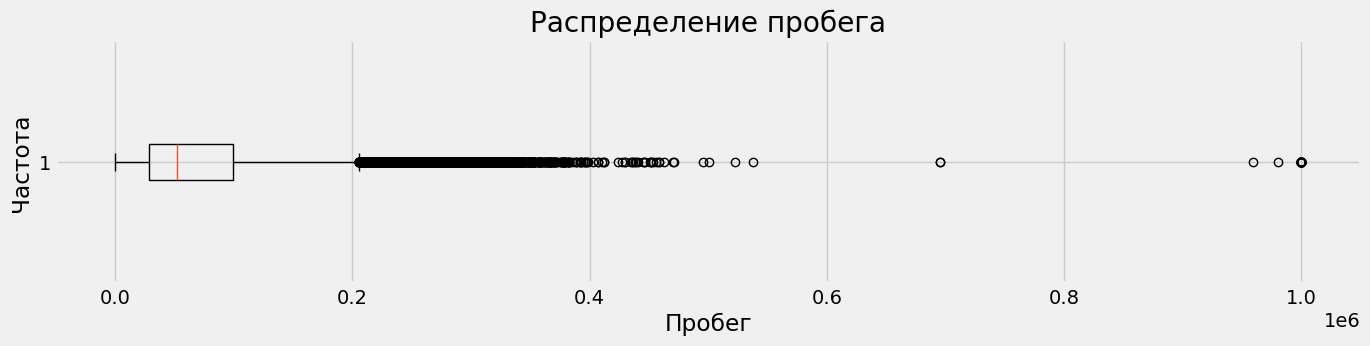

In [57]:
plt.figure(figsize=(15,3))
plt.boxplot(data['odometer'],vert = False);
plt.title ('Распределение пробега');
plt.xlabel ('Пробег');
plt.ylabel ('Частота');


In [58]:
data[data['odometer']  == 999999.00].count()

year            55
make            55
model           55
trim            55
body            55
transmission    55
vin             55
state           55
condition       55
odometer        55
color           55
interior        55
seller          55
sellingprice    55
saledate        55
dtype: int64

Мы получили 55 строк с аномально большим пробегом. Возможно ошибка в данных.  Пробег достаточно важный признак. При удалении этих строк из данных среднее сильно не поменялось.Оставим эти строки.

In [59]:
# проверим наличие дубликатов после предобработки

print(data.duplicated().sum())
print(test.duplicated().sum())

0
0


In [60]:
# удалим столбец с vin.т.к. больше он для нас не информативен
data = data.drop('vin', axis= 1)

In [61]:
data.shape,test.shape

((440236, 14), (110058, 14))

In [62]:
data.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,ford,Edge,SEL,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-01 19:30:00+00:00
1,2014,ford,Fusion,SE,sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00
2,2012,nissan,Sentra,2.0 SL,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00
3,2003,hummer,H2,Base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-16 20:00:00+00:00
4,2007,ford,Fusion,SEL,sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,2015-02-02 20:00:00+00:00


**После предобработки данных (обучающего и тестового набора) мы получили следующую информацию:**

1. Изменены типы данных в столбце 'saledate'. В результате выяснили, что данные представлены за период c 2014-01-01 01:15:00+00:00 по 2015-07-20 19:30:00+00:00. В тесте c 2014-01-01 01:15:00+00:00 по 2015-07-13 23:30:00+00:00. Продажи были с понедельника по пятницу и в воскресенье. В субботу продаж не было.
2. Удалось заполнить пропущенные значения в столбце `make`, получив информацию из vin кода.
3. Пропуски в столбце `transmission` заполнили на основе группировки по году, марке, модели авто и получению методом idmax наиболее вероятного значения. Оставшиеся 0,4 % пропусков были заполнены модой на основании группировки столбцов (год, марка, модель) авто. В тесте заменены аналогично трейну.
4. В `condition` заполнили средним значением, т.к. не знаем, в каком состоянии находится авто на момент аукциона,
5. В `odometer` заполнили средним значением, на основании группировки по трем столбцам `make`,`model`,`year`;
оставшиеся пропуски в датафрейме заполним заглушкой '—', т.к данная заглушка у нас уже встречается в данных, чтобы впоследствии не "путать" модель.
6. В тесте замена пропусков произведена аналогично трейну, используя полученные значения из трейна.
6. Поработали с неявными дубликатами в столбцах `make`и `body`. Путем приведения к нижнему регистру удалось снизить количество дубликатов только в столбце `body`.
7. Посмотрели столбец с пробегом, выявили 55 строк с аномально большим пробегом, оставили без изменений.
8. Столбец `vin` удалили из трейна т.к. он для нас не информативен при обучении модели в дальнейшем. В тесте оставили.
9. После изучения всех признаков мы получили обучающий датасет размером (440236, 14) и тестовый (110058, 14)).

## Исследовательский анализ данных (EDA)

В целях подготовки и изучения данных проведем исследовательский анализ данных (EDA), который состоит из следующих этапов:

* изучение целевого признака;   
* изучение признаков для обучения;   
* изучение влияния признаков на таргет;   
* разработка новых синтетических признаков и изучение корреляции.
* отбор финального набора обучающих признаков.

**Изучим целевой признак**

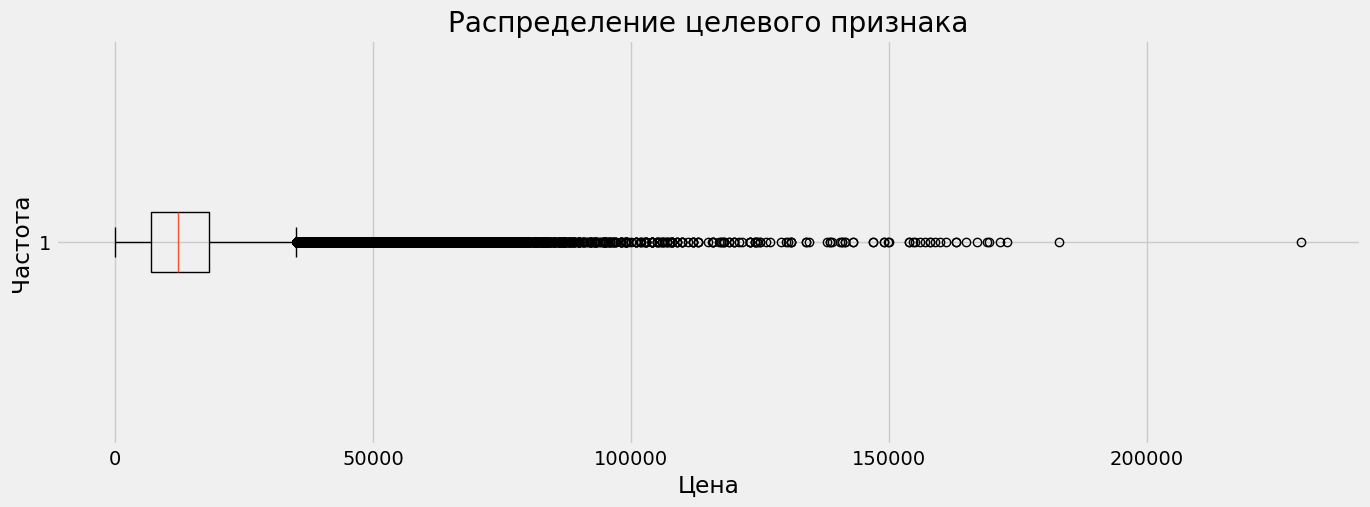

In [63]:
plt.figure(figsize=(15,5))
plt.boxplot(data['sellingprice'],vert = False);
plt.title ('Распределение целевого признака');
plt.xlabel ('Цена');
plt.ylabel ('Частота');

In [64]:
data['sellingprice'].describe()

count    440236.000000
mean      13592.209588
std        9751.479098
min           1.000000
25%        6900.000000
50%       12100.000000
75%       18200.000000
max      230000.000000
Name: sellingprice, dtype: float64

In [65]:
data['sellingprice'].value_counts()

11000    3510
12000    3499
13000    3374
10000    3178
14000    3104
         ... 
57100       1
73100       1
41501       1
66700       1
2725        1
Name: sellingprice, Length: 1735, dtype: int64

**Вывод по целевому признаку**:

Мы видим, что в среднем автомобили продаются за 13592 ед.    
Разброс цен довольно большой, как указывает стандартное отклонение в размере 9751 ед.   
Минимальная цена составляет всего 1 ед., что может указывать на наличие выбросов или ошибок в данных.   
Медиана составляет 12100 ед., что означает, что половина наблюдений имеют цены ниже этого значения.   
75% автомобилей имеют цены ниже 18,200 долларов.   
Так как это наш целевой признак, вмешиваться в данные не будем и оставим все как есть.   

**Посмотрим матрицу корреляции числовых признаков и выведем тепловую карту для наглядности.**

In [66]:
data.corr(numeric_only = True)

,year,condition,odometer,sellingprice
year,1.000000,0.560571,-0.774541,0.586847
condition,0.560571,1.000000,-0.544564,0.544936
odometer,-0.774541,-0.544564,1.000000,-0.583109
sellingprice,0.586847,0.544936,-0.583109,1.000000


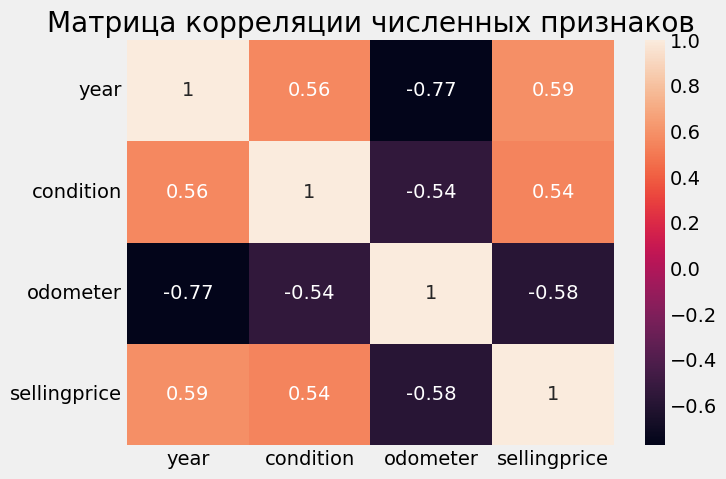

In [67]:
plt.figure(figsize=(7, 5))
plt.title('Матрица корреляции численных признаков')

sns.heatmap(data.corr(),annot = True)
plt.show()

Мы видим среднюю корреляцию между числовыми данными и нашим таргетом. Наибольший интерес заслуживает наличие отрицательной взаимосвязи между пробегом и стоимостью при продаже (-0,77), что логично, ведь чем больше пробег у авто, тем ниже ее цена. Также есть корреляция между годом регистрации и ценой (0,59) и между состоянием авто и ценой (0,56).

In [68]:
# построим таблицу корреляции смешанных признаков
#phik_overview = data.sample().phik_matrix()
# округлим значения коэффициентов для удобства
#phik_overview.round(2)

In [69]:
#data_drop = data.sample().drop(columns=['body','make','seller','trim','state'])
#phik_overview = data_drop.phik_matrix()
#phik_overview.round(2)

Библиотеку PHIK использовать не удалось, вероятно из-за размеров датасета и ограничений мощности jupyterHyb.Попробовала взять sample и убрать часть категориальных признаков с большим количеством уникальных значений, но тоже ничего не получилось.

**Создадим новый признак - возраст авто.**

In [70]:
data['age'] = pd.to_datetime(data['saledate'], utc=True).dt.year - data['year']

In [71]:
data.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saledate,age
0,2011,ford,Edge,SEL,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-01 19:30:00+00:00,4
1,2014,ford,Fusion,SE,sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00,1
2,2012,nissan,Sentra,2.0 SL,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00,3
3,2003,hummer,H2,Base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-16 20:00:00+00:00,12
4,2007,ford,Fusion,SEL,sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,2015-02-02 20:00:00+00:00,8


In [72]:
test['age'] = pd.to_datetime(test['saledate'], utc=True).dt.year - test['year']

**Создадим новый признак - пробег в год**

In [73]:
data['run_per_year'] = data['odometer'] / data['age']

**Создадим новый признак - год продажи**

In [74]:
data['year_of_sale'] = pd.to_datetime(data['saledate'], utc=True).dt.year

In [75]:
data.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saledate,age,run_per_year,year_of_sale
0,2011,ford,Edge,SEL,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-01 19:30:00+00:00,4,27760.250,2015
1,2014,ford,Fusion,SE,sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00,1,31034.000,2015
2,2012,nissan,Sentra,2.0 SL,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00,3,11873.000,2015
3,2003,hummer,H2,Base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-16 20:00:00+00:00,12,10941.750,2015
4,2007,ford,Fusion,SEL,sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,2015-02-02 20:00:00+00:00,8,15963.625,2015


In [76]:
test['year_of_sale'] = pd.to_datetime(test['saledate'], utc=True).dt.year

**Создадим новый признак - день продажи**

In [77]:
data['day_of_sale'] = pd.to_datetime(data['saledate'], utc=True).dt.weekday

In [78]:
test['day_of_sale'] = pd.to_datetime(test['saledate'], utc=True).dt.weekday

**Target encoding**

**Создадим новый признак на основе средней цены продажи (`sellingprice`) для каждого уникального значения в столбце `make`**


In [79]:
data['make_target'] = data['make'].map(data.groupby('make')['sellingprice'].mean()).astype('int64')
test['make_target'] = test['make'].map(data.groupby('make')['sellingprice'].mean()).fillna(0).astype('int64')

**Создадим новый признак на основе средней цены продажи (`sellingprice`) для каждого уникального значения в столбце `model`**

In [80]:
data['model_target'] = data['model'].map(data.groupby('model')['sellingprice'].mean()).astype('int64')
test['model_target'] = test['model'].map(data.groupby('model')['sellingprice'].mean()).fillna(0).astype('int64')

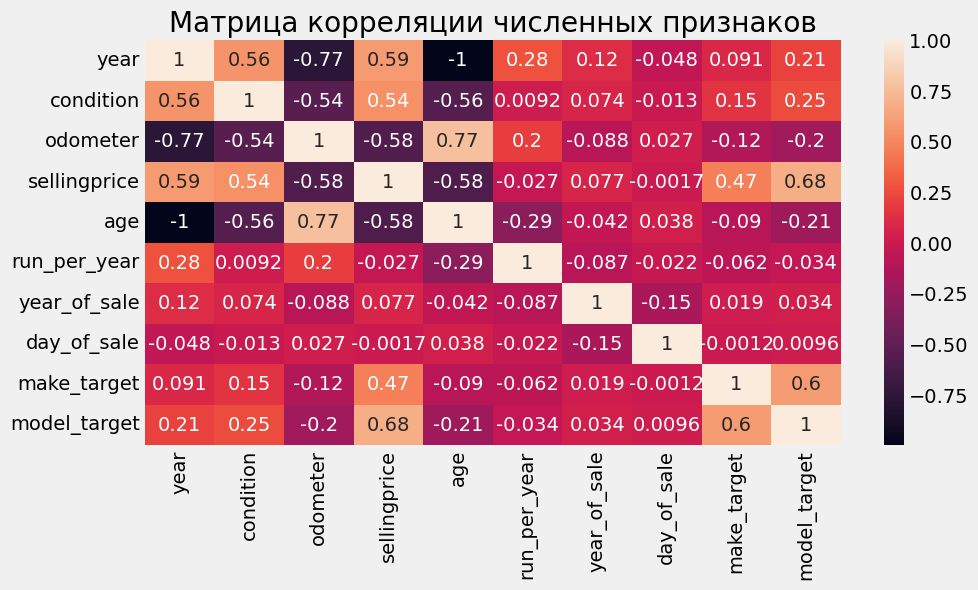

In [81]:
# рассмотрим еще раз тепловую карту после создания новых признаков
plt.figure(figsize=(10, 5))
plt.title('Матрица корреляции численных признаков')

sns.heatmap(data.corr(),annot = True)
plt.show()

Корреляция между годом продажи и ценой очень слабая (0,077).
Корреляция между пробегом в год отрицательная и ценой также довольно слабая(-0.027).
Думаю стоит удалить данные признаки и не использовать в модели.

Обратим также внимание на признаки `age` и `year`.
Сильная взаимная корреляция между признаками может оказать влияние на обучение модели в нескольких аспектах:
    
* Мультиколлинеарность: Если два или более признака сильно коррелируют между собой, они предоставляют похожую информацию модели. Это может вызвать проблему мультиколлинеарности, когда модель становится чувствительной к малым изменениям входных данных и может иметь трудности в интерпретации весов признаков. Мультиколлинеарность также может привести к нестабильным оценкам параметров модели;
* Увеличение сложности модели: Признаки с сильной корреляцией добавляют дублирующую информацию, что может привести к увеличению сложности модели без значительного улучшения предсказательной способности. Это может привести к переобучению, особенно если количество признаков превышает количество доступных обучающих примеров;
* Плохая обобщающая способность: Если модель обучается на данных с сильной корреляцией между признаками, она может стать чувствительной к этой особенности и не будет хорошо обобщать на новые данные, где корреляция может быть отличной;
* Увеличение времени обучения: Когда признаки сильно коррелируют между собой, модель может занимать больше времени на обучение. Это происходит потому, что модель должна вычислить и корректировать веса для каждого коррелирующего признака, что может потребовать больше вычислительных ресурсов.

Удалим признаки `run_per_year`,`year_of_sale` после исследования зависимостей наиболее интересных категориальных признаков и цены.

In [82]:
data.shape, test.shape

((440236, 20), (110058, 19))

Рассмотрим наиболее интересные взаимосвязи наших категориальных признаков с помощью визуализации и решим какие признаки оставить.

**Марка автомобиля (`make`)**

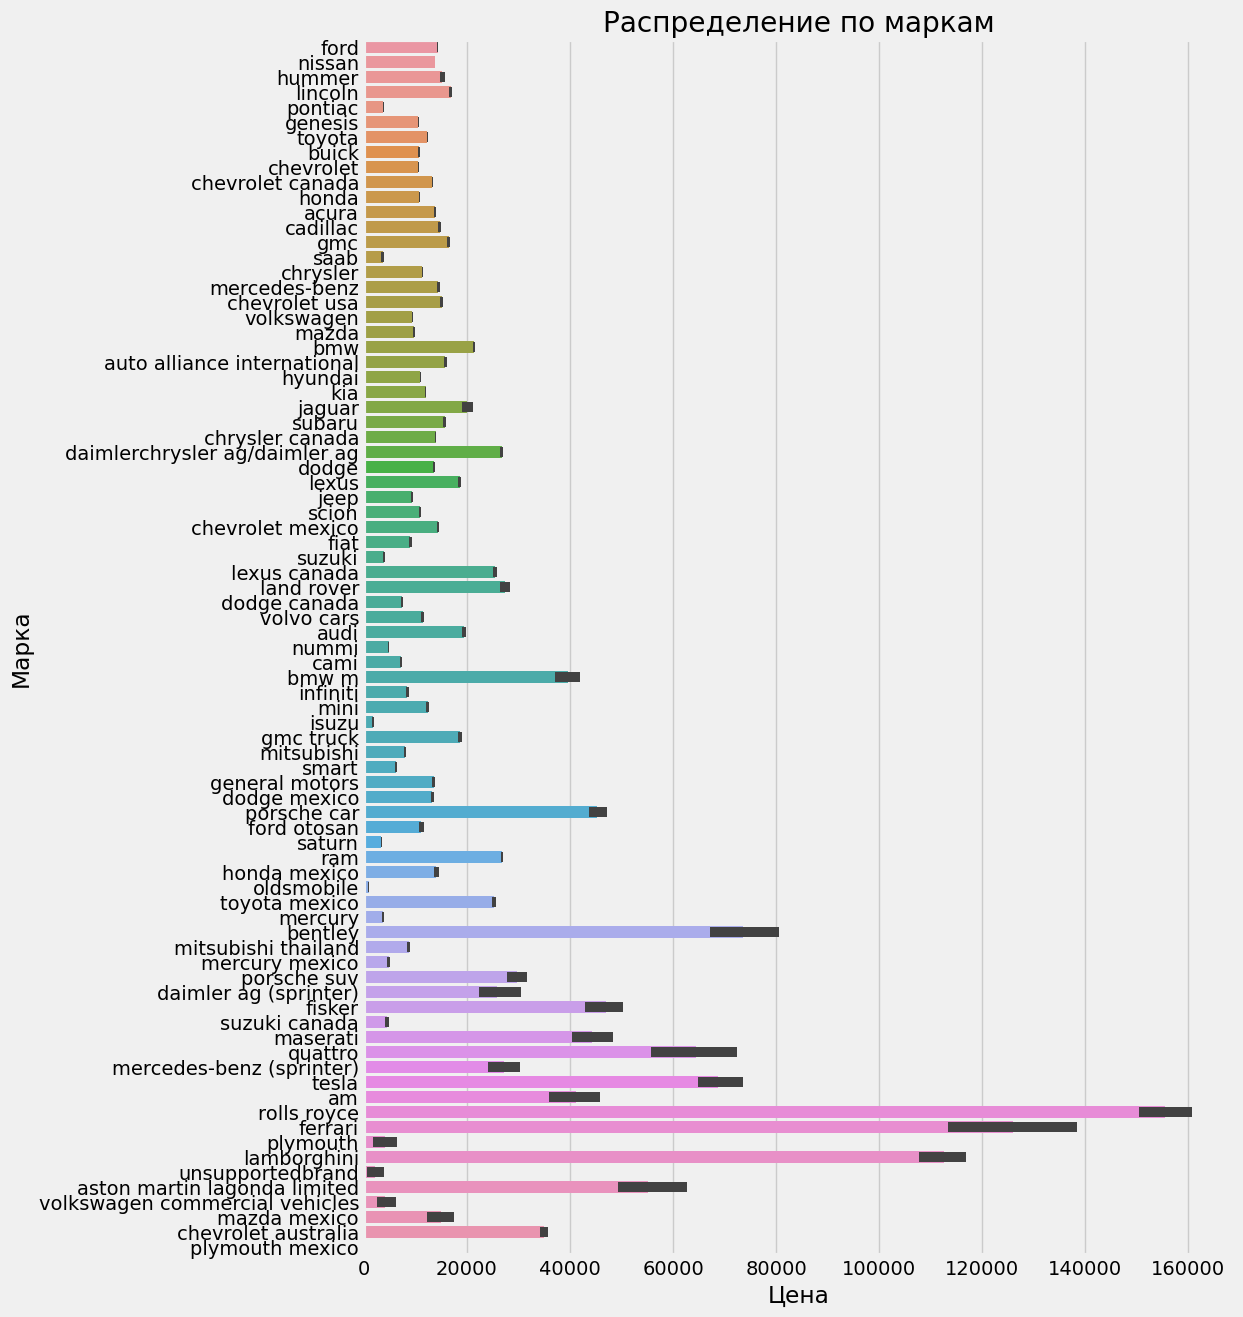

In [83]:
# построим барплот зависимости цены от марки авто

plt.figure(figsize=(10,15))
sns.barplot(x=data['sellingprice'],y=data['make']);
plt.title ('Распределение по маркам');
plt.xlabel ('Цена');
plt.ylabel ('Марка');
plt.show()

Здесь мы наглядно видим, что средние цены на автомобили люксового класса(rolls royce,ferrari,lamborgini) гораздо выше чем на автомобили среднего класса (ford,nissan,honda и др.).

Зависимость цены от модели и уровня отделки салона строить не будем, т.к. там слишком много разнообразных значений.

**Тип кузова (`body`)**

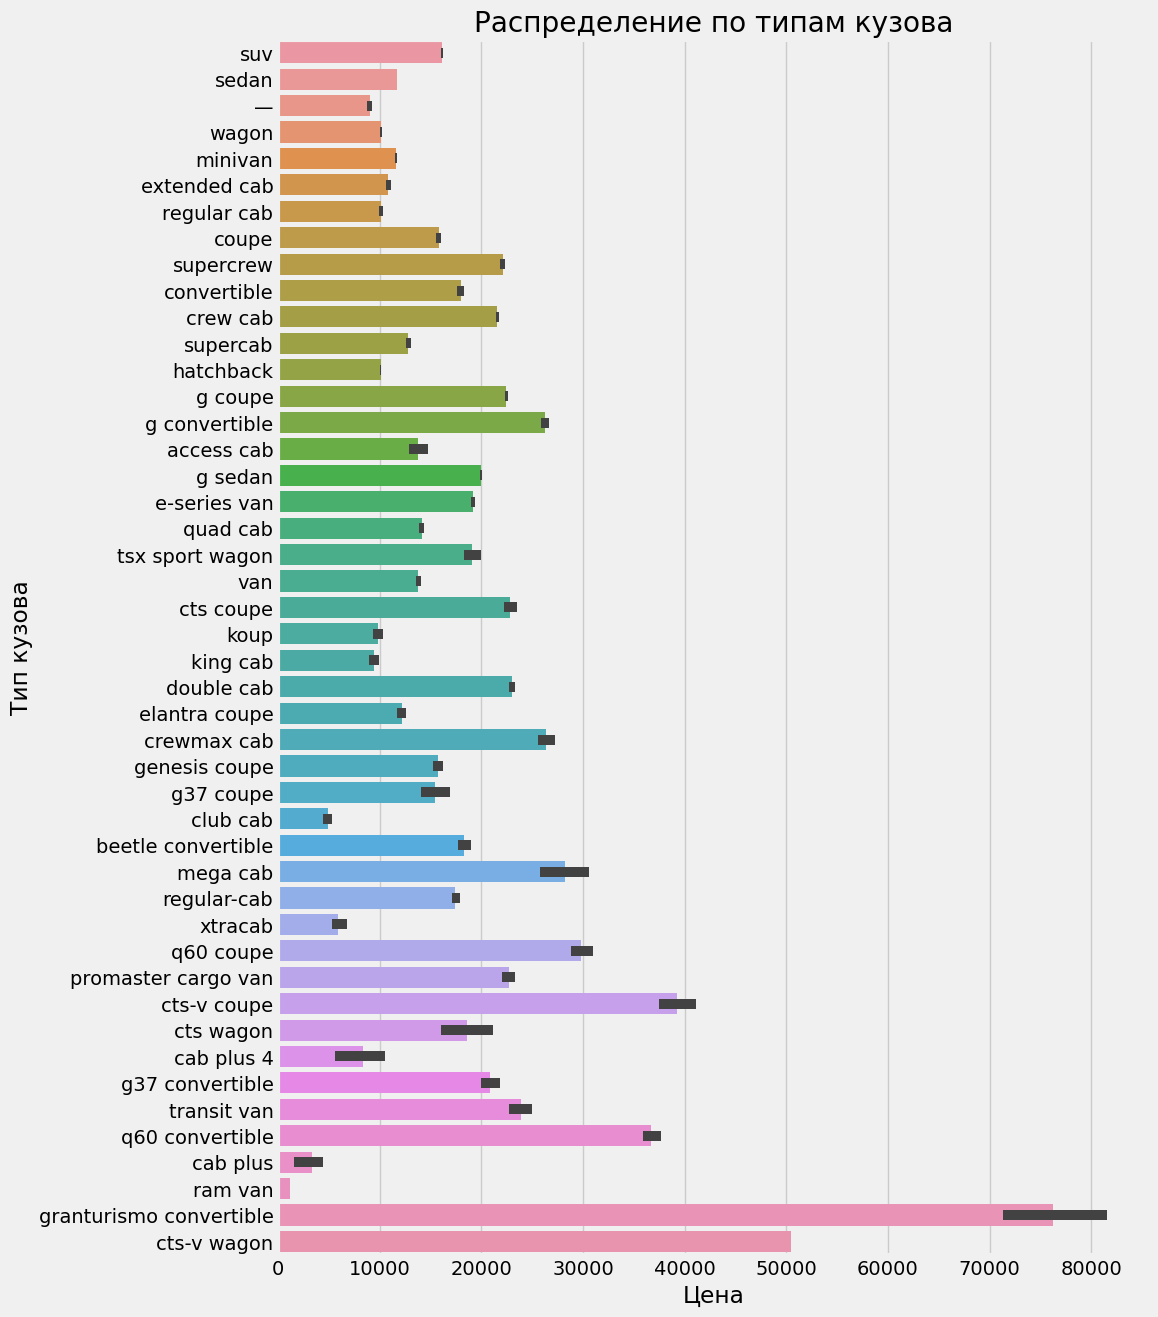

In [84]:
# построим барплот зависимости цены от типа кузова авто

plt.figure(figsize=(10,15))
sns.barplot(x=data['sellingprice'],y=data['body']);
plt.title ('Распределение по типам кузова');
plt.xlabel ('Цена');
plt.ylabel ('Тип кузова');
plt.show()

**Трансмиссия (`transmission`)**

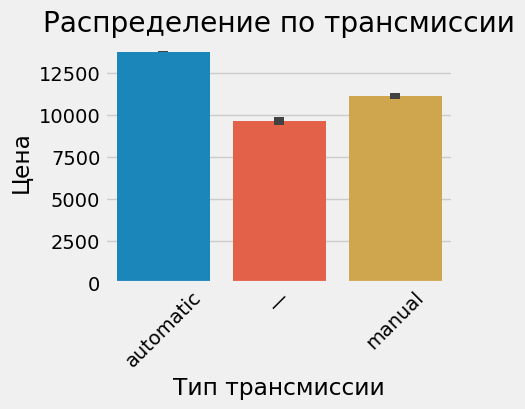

In [85]:
# построим барплот зависимости цены от типа трансмиссии авто

plt.figure(figsize=(4,3))
sns.barplot(x=data['transmission'],y=data['sellingprice']);
plt.title ('Распределение по трансмиссии');
plt.xlabel ('Тип трансмиссии');
plt.ylabel ('Цена');
plt.xticks(rotation = 45)
plt.show()

Естественно машины с автоматической коробкой передач в среднем стоят дороже механики.

**Цвет кузова (`color`)**

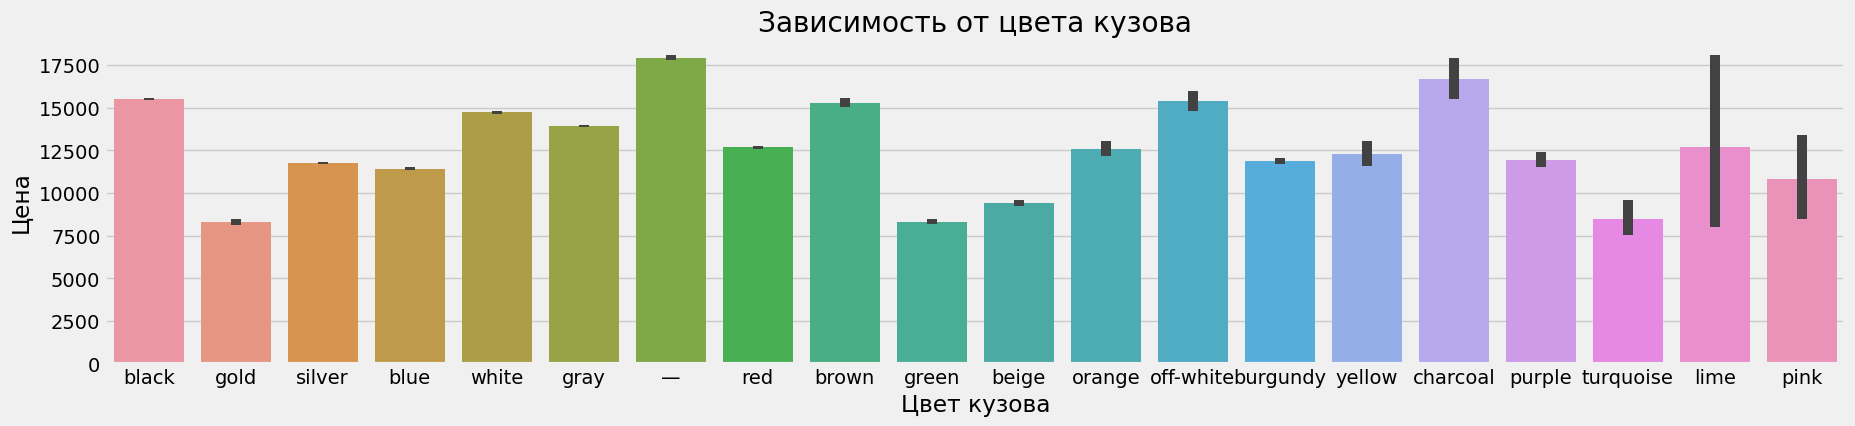

In [86]:
# построим барплот зависимости цены от цвета кузова

plt.figure(figsize=(20,4))
sns.barplot(x=data['color'],y=data['sellingprice']);
plt.title ('Зависимость от цвета кузова');
plt.xlabel ('Цвет кузова');
plt.ylabel ('Цена');
plt.show()

Дороже всего машины с цветом у которого стоит '-'. Далее идут цвет 'charcoal' и затем черные авто. Дешевле всего машины золотого, зеленого и бирюзового цвета.

**Цвет салона (`interior`)**

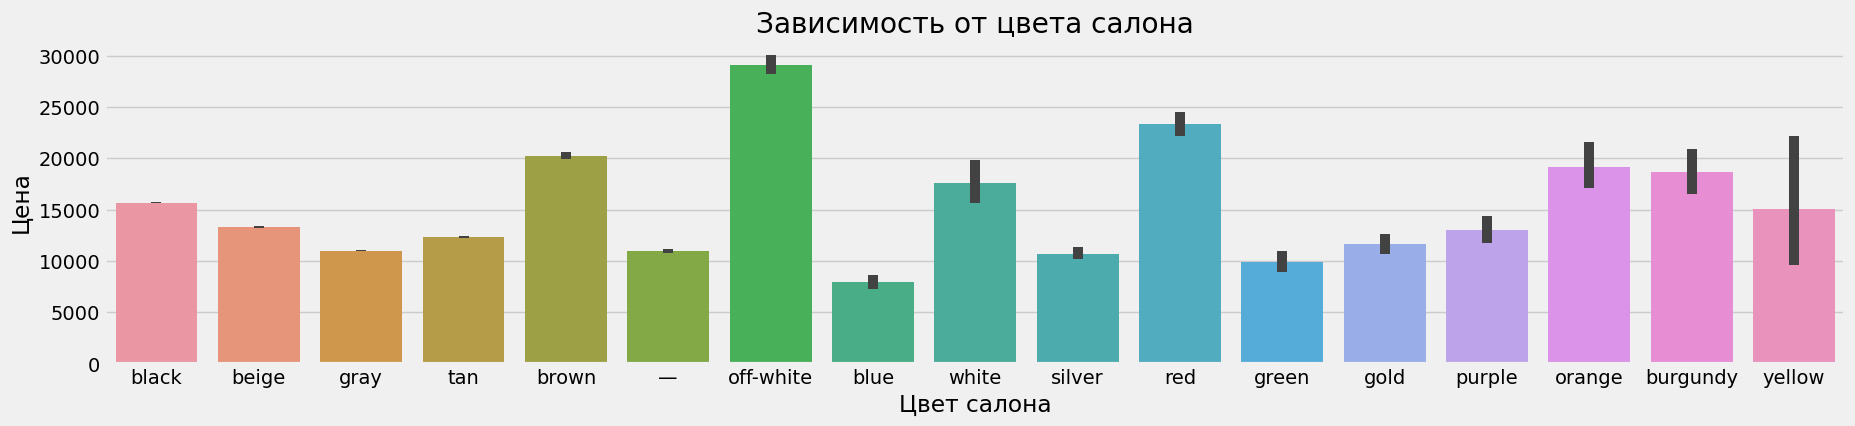

In [87]:
# построим барплот зависимости цены от цвета салона

plt.figure(figsize=(20,4))
sns.barplot(x=data['interior'],y=data['sellingprice']);
plt.title ('Зависимость от цвета салона');
plt.xlabel ('Цвет салона');
plt.ylabel ('Цена');
plt.show()

Здесь самые дорогие это с цветом 'off-white', затем с красной отделкой. Самые дешевые в голубой отделке.

**Год выпуска (`year`)**

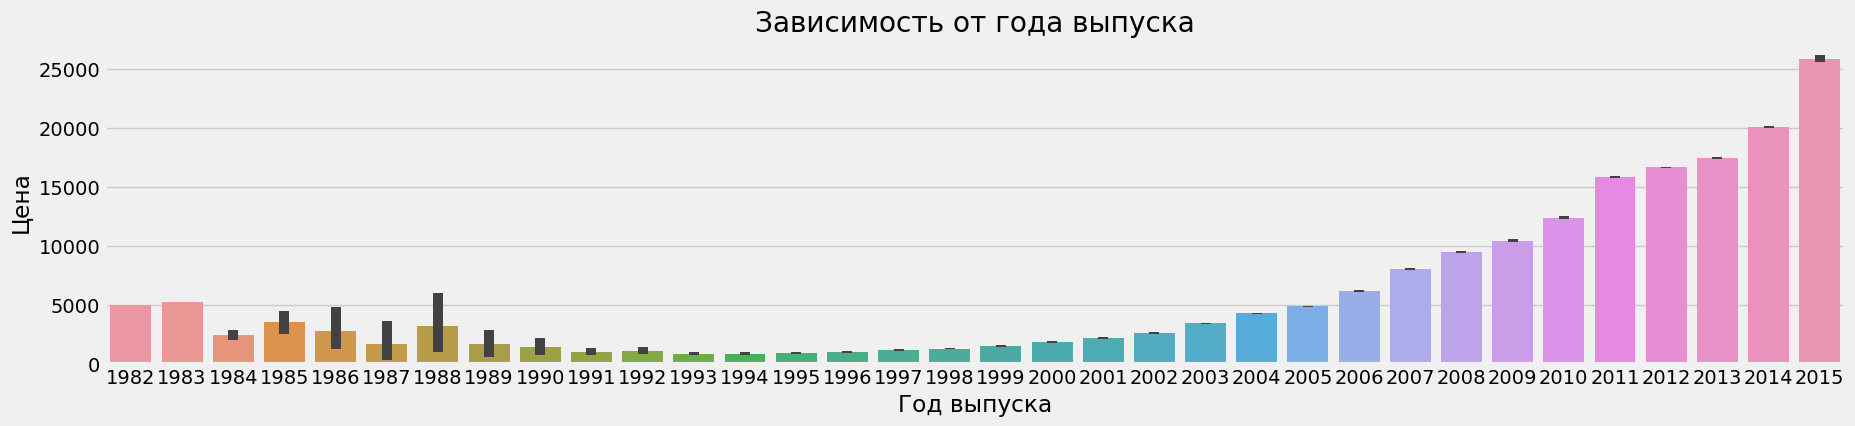

In [88]:
# построим барплот зависимости цены от года выпуска авто

plt.figure(figsize=(20,4))
sns.barplot(x=data['year'],y=data['sellingprice']);
plt.title ('Зависимость от года выпуска');
plt.xlabel ('Год выпуска');
plt.ylabel ('Цена');
plt.show()

Все логично, новые машины продаются по более высокой цене, в отличие от своих предшественников по году выпуска.

In [89]:
data.groupby(['age'])['sellingprice'].count()


age
-1       166
 0     11411
 1     65479
 2     78167
 3     78716
 4     36222
 5     20291
 6     17116
 7     24868
 8     23941
 9     20613
 10    16445
 11    13287
 12    10182
 13     7285
 14     5026
 15     3895
 16     2496
 17     1638
 18     1149
 19      651
 20      502
 21      299
 22      162
 23       93
 24       51
 25       34
 26       11
 27       12
 28        5
 29       10
 30        7
 31        4
 32        1
 33        1
Name: sellingprice, dtype: int64

Здесь мы видим, что 166 машин были выпущены в 2015 г. по документам, а проданы в 2014 г. Следует уточнить эту информацию. Возможно стоит удалить эти строки?

In [90]:
data = data.drop(['saledate','run_per_year','year_of_sale'], axis=1)

In [91]:
test = test.drop(['saledate','year_of_sale'], axis=1)

В рамках проведения экспериментов при обучении моделей и визуализации важности признаков выяснилось, что пробег за год и год продажи слабо влияет на метрику качества. Поэтому ранее было принято решение удалить данные столбцы. 

Объединим редко встречающиеся модели в категорию 'другие'

In [92]:
# Определим пороговое значение для объединения редких моделей
threshold = 10

# посчитаем количество вхождений каждой модели в столбце
model_counts = data['model'].value_counts()

# выберем модели, которые встречаются реже, чем пороговое значение
rare_models = model_counts[model_counts <= threshold].index

# заменим редкие значения в столбце на 'другие'
data['model'] = data['model'].replace(rare_models, 'другие')

In [93]:
# для тестовой выборки

# Посчитаем количество вхождений каждой модели в столбце
model_counts_test = test['model'].value_counts()

# выберем модели, которые встречаются реже, чем пороговое значение
rare_models_test = model_counts_test[model_counts_test <= threshold].index

# заменим редкие значения в столбце на 'другие'
test['model'] = test['model'].replace(rare_models, 'другие')

In [94]:
data.shape, test.shape

((440236, 17), (110058, 17))

**После проведения исследовательского анализа наших данных можно сделать следующие выводы:**

* в среднем автомобили продаются за 13592 ед. 
* из исходного датасета было удалено 2 неинформативных столбца: vin и saledate;
* из столбца `saledate` мы создали новый признак - `year_of_sale` (год продажи авто);
* создали новый признак - `age` (возраст авто);
* попробовали создать новый признак - `run_per_year` (пробег за год);
* также применили target encoding и создали 2 новый признака:
- на основе средней цены продажи (`sellingprice`) для каждого уникального значения в столбце `make`:`make_target`;
- на основе средней цены продажи (`sellingprice`) для каждого уникального значения в столбце `model`:`model_target`;
* при изучении тепловой карты корреляции, а также при дальнейших экспериментах при обучении моделей, принято решение удалить созданные признаки `run_per_year`,`year_of_sale` из-за слабой корреляции с таргетом и отсутствия влияния данных признаков на метрику;
* обнаружили 166 авто 2015 г. проданных в 2014 г.;
* увидели среднюю корреляцию между числовыми данными и нашим таргетом. Наибольший интерес заслуживает наличие отрицательной взаимосвязи между пробегом и стоимостью при продаже (-0,78), что логично, ведь чем больше пробег у авто, тем ниже ее цена. Также есть корреляция (0,56) между состоянием авто и ценой, и между годом регистрации и ценой(0,59).
* после изучения всех признаков мы получили обучающий датасет размером (440236, 17) и тестовый (110058, 17);

Данные готовы к обучению моделей.

## Выбор и обучение моделей

Подготовка призанков для обучения моделей.

In [95]:
# введем константу
RANDOM_STATE = 12345

In [96]:
# cоздадим переменные для признаков и целевого признака
X_train = data.drop('sellingprice', axis=1)
y_train = data['sellingprice']

Чтобы полнее использовать датасет, можно не выделять валидационную выборку, а вместо этого будем использовать кросс-валидацию.

In [97]:
#X_train, X_valid, y_train, y_valid = train_test_split(
    #features, target, test_size=0.25, random_state=RANDOM_STATE)

In [98]:
# выведем на экран размеры таблиц, которые хранятся в 2-х переменных
X_train.shape,y_train.shape

((440236, 16), (440236,))

### Обучение моделей

**Построим Baseline модель для последующей проверки наших моделей на адекватность**

In [99]:
dummy_model = DummyRegressor(strategy="mean")

scores = cross_val_score(dummy_model, X_train, y_train, scoring=make_scorer(mean_absolute_percentage_error), cv=5)
dummy_model.fit(X_train, y_train)

dummy_model_mape = scores.mean()

print(f'DummyRegressor with cross-validation: {dummy_model_mape}')

DummyRegressor with cross-validation: 1.8734605032564429


**Подготовим данные для обучения моделей линейной регрессии и случайного леса**

In [100]:
X_train_lr= X_train.copy()

In [101]:
categorical_mask = (X_train_lr.dtypes=='object')
categorical_columns = X_train_lr.columns[categorical_mask].tolist()
num_cols = X_train_lr.select_dtypes(include=['int64','float64']).columns.tolist()
oe_cols = [c for c in categorical_columns if X_train_lr[c].nunique()>5]
ohe_cols = [c for c in categorical_columns if X_train_lr[c].nunique()<=5]
len(oe_cols), len(ohe_cols), len(num_cols)

(8, 1, 7)

In [102]:
ohe_unique_list = [X_train_lr[c].unique().tolist() for c in ohe_cols]
oe_unique_list = [X_train_lr[c].unique().tolist() for c in oe_cols]
ohe = OneHotEncoder(categories=ohe_unique_list)
oe = OrdinalEncoder(categories=oe_unique_list)

In [103]:
# кодируем категориальные признаки и масштабируем численные с помощью make_column_transformer

col_transformer_lr = make_column_transformer(
    (
        OneHotEncoder(handle_unknown = 'ignore', drop = 'first', sparse = False),
        ohe_cols
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        oe_cols
    ),
        
    (
        StandardScaler(), 
      num_cols
    ),remainder='passthrough',
    verbose_feature_names_out=False
)

In [104]:
X_train_lr  = pd.DataFrame(
    col_transformer_lr.fit_transform(X_train_lr),
    columns = col_transformer_lr.get_feature_names_out()
)
X_train_lr 

,transmission_manual,transmission_—,make,model,trim,body,state,color,interior,seller,year,condition,odometer,age,day_of_sale,make_target,model_target
0,0.0,0.0,26.0,171.0,1228.0,39.0,12.0,1.0,1.0,10697.0,0.241305,0.831693,0.797229,-0.218090,-1.185769,0.151497,0.783434
1,0.0,0.0,26.0,229.0,1201.0,36.0,15.0,1.0,1.0,736.0,0.995464,0.092724,-0.696966,-0.976742,-0.381450,0.151497,-0.184080
2,0.0,0.0,56.0,490.0,69.0,36.0,19.0,1.0,1.0,8503.0,0.492692,-1.279648,-0.611338,-0.470974,-0.381450,0.049882,-0.726415
3,0.0,0.0,34.0,271.0,552.0,39.0,33.0,6.0,0.0,12845.0,-1.769785,-0.646246,1.175601,1.804982,-0.381450,0.349047,0.736841
4,0.0,0.0,26.0,229.0,1228.0,36.0,12.0,1.0,1.0,9750.0,-0.764240,-1.490782,1.108518,0.793446,-1.185769,0.151497,-0.184080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440231,0.0,0.0,40.0,388.0,737.0,36.0,3.0,17.0,0.0,6582.0,0.744078,1.148394,-0.894930,-0.723858,-1.185769,-0.341502,-0.026473
440232,0.0,0.0,53.0,136.0,1165.0,43.0,37.0,17.0,1.0,1834.0,0.995464,-0.540678,-1.002484,-0.976742,-0.381450,-0.272010,0.825832
440233,0.0,0.0,6.0,23.0,491.0,6.0,3.0,7.0,1.0,11349.0,-0.512854,0.303858,0.638690,0.540562,-1.185769,1.703920,2.960115
440234,0.0,0.0,65.0,5.0,1274.0,7.0,33.0,17.0,6.0,4340.0,0.995464,-0.435111,-0.728099,-0.976742,-0.381450,2.885282,2.839363


In [105]:
# кодируем категориальные признаки и масштабируем численные для модели линейной регрессии

#col_transformer_lr = make_column_transformer(
    #(
        #OneHotEncoder(handle_unknown = 'ignore', drop = 'first', sparse = False, min_frequency=20),
        #ohe_cols
    #),
    #(
        #StandardScaler(), 
        #num_cols
    #),remainder='passthrough',
    #verbose_feature_names_out=False
#)

Данные закодированные OrdinalEncoder не подходят для обучения линейной регрессии, их стоит кодировать OneHotEncoder, но при такой кодировке у меня возникала ошибка памяти: 'MemoryError: Unable to allocate 11.9 GiB for an array with shape (440236, 3631) and data type float64'.

**Lasso регрессия**

In [106]:
pipeline_lasso = Pipeline([
    ('lasso', Lasso())
])

parameters_lasso = {
    'lasso__alpha': [0.1, 0.5, 1.0] 
}

gs_model_lasso = GridSearchCV(
    estimator=pipeline_lasso,
    param_grid=parameters_lasso,
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1
)

In [107]:
%%time
gs_model_lasso.fit(X_train_lr, y_train)

CPU times: total: 39.9 s
Wall time: 7min 35s


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('lasso', Lasso())]), n_jobs=-1,
             param_grid={'lasso__alpha': [0.1, 0.5, 1.0]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [108]:
best_params_lasso = gs_model_lasso.best_params_
best_params_lasso

{'lasso__alpha': 1.0}

In [109]:
best_model_lasso = gs_model_lasso.best_estimator_
best_model_lasso

Pipeline(steps=[('lasso', Lasso())])

In [110]:
best_score_lasso = -gs_model_lasso.best_score_

print(f'Лучшее MAPE модели Lasso на кросс-валидации: {best_score_lasso}')

Лучшее MAPE модели Lasso на кросс-валидации: 0.7826976652705987


In [111]:
lasso_coefs = best_model_lasso.named_steps['lasso'].coef_


In [112]:
importances_lasso = pd.Series(
    best_model_lasso.named_steps['lasso'].coef_,
    index=X_train_lr.columns
).sort_values(ascending=False)

importances_lasso


model_target           4758.543026
transmission_—         2411.764829
year                   2107.379025
condition              1631.739633
make_target            1003.649360
day_of_sale              97.095479
state                     2.396248
model                     2.029527
trim                      0.484187
age                       0.000000
seller                   -0.058435
interior                 -3.101124
make                     -4.991807
color                   -14.442370
body                    -39.223939
transmission_manual    -507.715052
odometer              -2148.364245
dtype: float64

**Модель линейной регрессии LinearRegression**

In [113]:
pipeline_linear = Pipeline([
    ('lr', LinearRegression())
])

parameters_linear = {}

gs_model_linear = GridSearchCV(
    estimator=pipeline_linear,
    param_grid=parameters_linear,
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1
)

In [114]:
%%time
gs_model_linear.fit(X_train_lr, y_train)

CPU times: total: 1.08 s
Wall time: 11.2 s


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('lr', LinearRegression())]), n_jobs=-1,
             param_grid={},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [115]:
best_params_lr = gs_model_linear.best_params_
best_params_lr

{}

In [116]:
best_model_lr = gs_model_linear.best_estimator_
best_model_lr

Pipeline(steps=[('lr', LinearRegression())])

In [117]:
best_score_lr = -gs_model_linear.best_score_

print(f'Лучшее MAPE модели линейной регрессии на кросс-валидации: {best_score_lr}')

Лучшее MAPE модели линейной регрессии на кросс-валидации: 0.7831768288456832


MAPE показал очень высокий показатель. Линейная регрессия дает плохой результат. Возможно, если бы использовали другой кодировщик метрика была бы лучше.

**Модель RandomForestRegressor**

In [118]:
pipeline_rf = Pipeline([
    ('rf', RandomForestRegressor())
])

parameters_rf = {
    'rf__n_estimators': [100],
    'rf__max_depth': [5, 10]
}

gs_model_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=parameters_rf,
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1
)

In [119]:
%%time
gs_model_rf.fit(X_train_lr, y_train)

CPU times: total: 3min 36s
Wall time: 15min 37s


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10], 'rf__n_estimators': [100]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [120]:
best_params_rf = gs_model_rf.best_params_
best_params_rf

{'rf__max_depth': 10, 'rf__n_estimators': 100}

In [121]:
# посмотрим метрику MAPE

best_score_rf = -gs_model_rf.best_score_
print(f'Лучшее MAPE для RandomForestRegressor на кросс-валидации: {best_score_rf}')

Лучшее MAPE для RandomForestRegressor на кросс-валидации: 0.2761927464685031


RandomForestRegressor дал результат гораздо лучше линейной регрессии, но все еще достаточно высокий. 

In [122]:
best_rf_model = gs_model_rf.best_estimator_
rf_model = best_rf_model.named_steps['rf']

Напишем функцию для визуализации важности признаков для модели RandomForestRegressor.

In [123]:
def plot_feature_importance(importance,names,model_type):

    # создадим массивы из важности признаков и названий признаков
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # создадим DataFrame с использованием словаря
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # отсортируем DataFrame по убыванию важности признаков
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    # определим размер 
    plt.figure(figsize=(10,8))
    # создадим столбчатую диаграмму с помощью Seaborn
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # добавим подписи 
    plt.title('Важность признаков для'+ model_type)
    plt.xlabel('Важность признаков')
    plt.ylabel('Признаки')

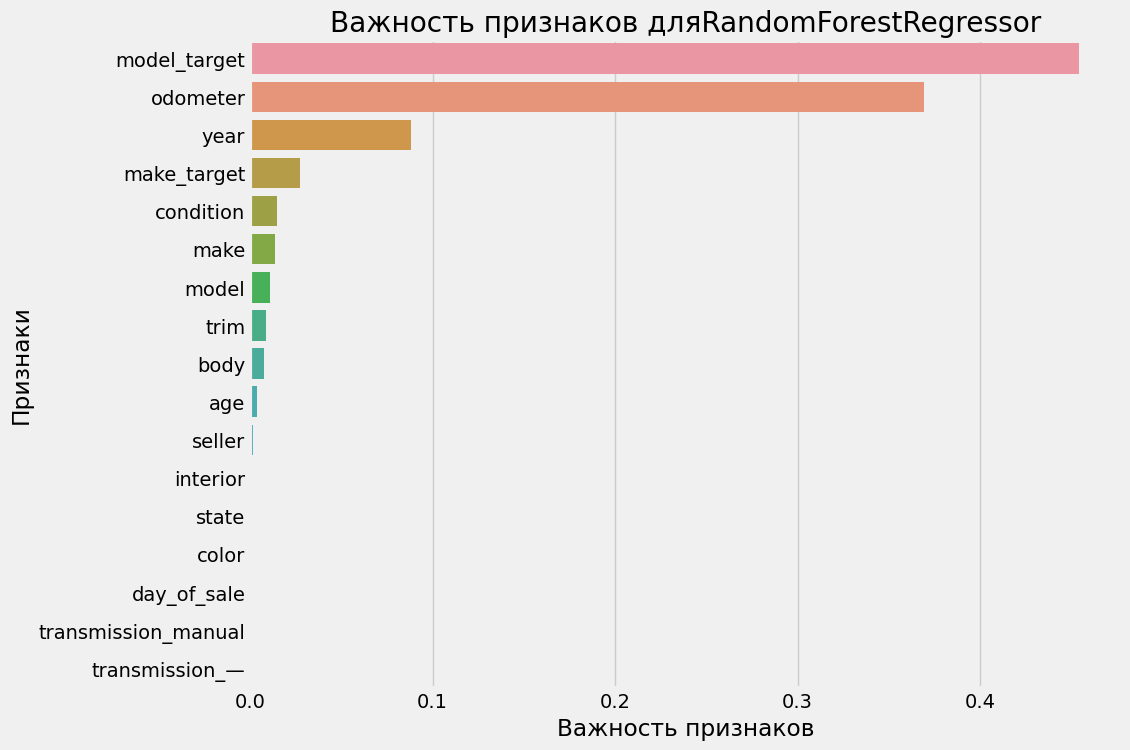

In [124]:
plot_feature_importance(rf_model.feature_importances_, X_train_lr.columns, 'RandomForestRegressor')


Рассмотрим для сравнения еще бустинговые модели.

**Модель CatBoostRegressor (без подбора гиперпараметров и кросс-валидации)**

In [125]:
# cоздадим переменные для признаков и целевого признака
features = data.drop('sellingprice', axis=1)
target = data['sellingprice']

Разобьем данные на выборки. Разделим исходные данные на обучающую и валидационную выборки. Данные разобьем на 2 части, в соотношении 75:25.

In [126]:
X_train, X_valid, y_train, y_valid = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [127]:
# выведем на экран размеры таблиц, которые хранятся в 4-х переменных
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape

((330177, 16), (330177,), (110059, 16), (110059,))

In [128]:
X_train_cb = X_train.copy()
X_valid_cb = X_valid.copy()

In [129]:
X_test = test.drop('vin', axis=1)

In [130]:
#численные признаки
num_cols = X_train_cb.select_dtypes(exclude='object').columns.to_list()
num_cols

['year',
 'condition',
 'odometer',
 'age',
 'day_of_sale',
 'make_target',
 'model_target']

In [131]:
# создадим переменную с категориальными признаками для передачи в модель
cat_features = X_train_cb.select_dtypes(include='object').columns.to_list()
cat_features

['make',
 'model',
 'trim',
 'body',
 'transmission',
 'state',
 'color',
 'interior',
 'seller']

In [132]:
# напишем функцию для подсчета MAPE
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# инициализируем модель CatBoostRegressor
cb = CatBoostRegressor(loss_function='RMSE',
                       random_state=RANDOM_STATE,
                       verbose=False,
                       iterations=300,
                       custom_metric=['MAPE'])

train_pool = Pool(X_train_cb, y_train, cat_features=cat_features)

In [133]:
%%time
cb.fit(train_pool)

CPU times: total: 6min 18s
Wall time: 3min 11s


In [134]:
predictions = cb.predict(X_valid_cb)
mape_score_cb = mape(y_valid, predictions)
print(f'MAPE для CatBoostRegressor без кросс-валидации: {mape_score_cb}')

MAPE для CatBoostRegressor без кросс-валидации: 0.21078248572182245


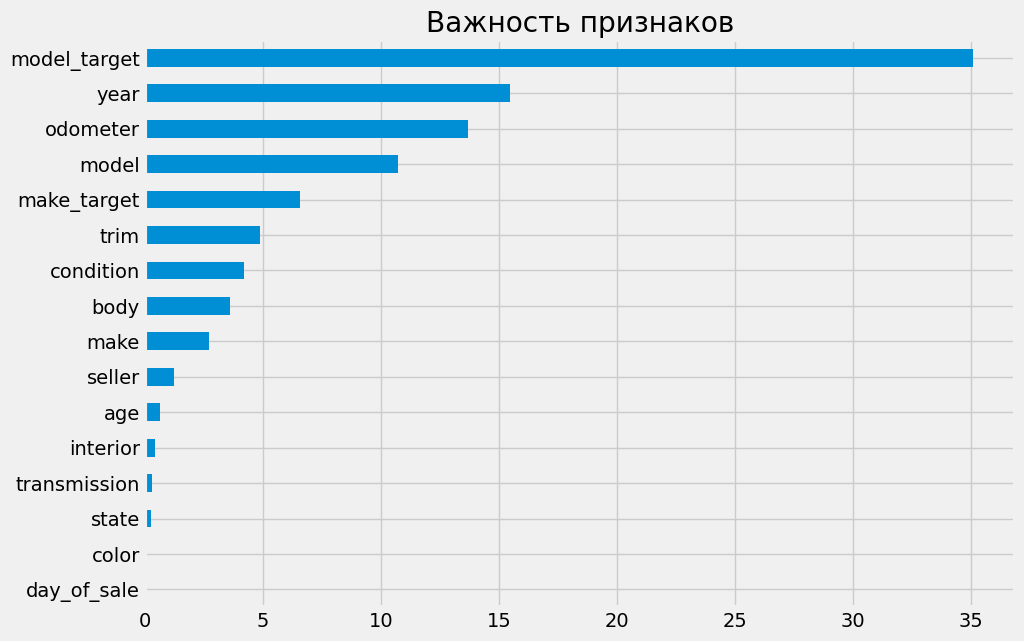

In [135]:
# построим гистограмму значимости признаков для модели CatBoost
# значения отсортированные по возрастанию влияния

plt.figure(figsize = (10,7))
importances = pd.Series(cb.feature_importances_,index=cb.feature_names_).sort_values()

# график
importances.plot.barh(grid=True, title='Важность признаков');

В предыдущем эксперименте выяснилось, что трансмиссия и год продажи совершенно не влияют на модель CatBoostRegressor. Поэтому приняли решение их удалить из датасета. В текущей версии все признаки оставлены.

**Модель CatBoostRegressor (c подбором гиперпараметров и кросс-валидацией)**

Данный блок закомментирован, чтобы заново не запускать процесс обучения. В ходе эксперимента выянилось, что данная модель дает результат хуже чем  LGBMRegressor

In [136]:
pipeline_catboost = Pipeline([
    ('cb', CatBoostRegressor(loss_function='RMSE',
                             random_state=RANDOM_STATE,
                             cat_features=cat_features))
])

parameters_catboost = {
    'cb__iterations': [300],
    'cb__depth': [4,6,8],
    'cb__learning_rate': [0.01,0.1,0.15]
}

In [137]:
gs_model_cb = GridSearchCV(
    estimator=pipeline_catboost,
    param_grid=parameters_catboost,
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1
)

In [138]:
%%time
gs_model_cb.fit(X_train_cb, y_train)

0:	learn: 8691.8991471	total: 5.14s	remaining: 25m 37s
1:	learn: 7805.8250364	total: 6.25s	remaining: 15m 31s
2:	learn: 7079.7211432	total: 7.12s	remaining: 11m 44s
3:	learn: 6449.0689224	total: 7.89s	remaining: 9m 43s
4:	learn: 5956.7826444	total: 8.5s	remaining: 8m 21s
5:	learn: 5518.4941235	total: 9.11s	remaining: 7m 26s
6:	learn: 5136.0912971	total: 9.79s	remaining: 6m 49s
7:	learn: 4819.7373828	total: 10.6s	remaining: 6m 25s
8:	learn: 4578.9384711	total: 11.2s	remaining: 6m 2s
9:	learn: 4338.4072433	total: 11.9s	remaining: 5m 44s
10:	learn: 4161.5400754	total: 12.5s	remaining: 5m 27s
11:	learn: 4002.6067039	total: 13.1s	remaining: 5m 14s
12:	learn: 3885.2929125	total: 13.7s	remaining: 5m 3s
13:	learn: 3776.3917979	total: 14.4s	remaining: 4m 54s
14:	learn: 3689.6655806	total: 14.9s	remaining: 4m 43s
15:	learn: 3599.5528619	total: 15.5s	remaining: 4m 35s
16:	learn: 3534.9718883	total: 16.1s	remaining: 4m 28s
17:	learn: 3470.0570574	total: 17s	remaining: 4m 26s
18:	learn: 3420.513721

GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('cb',
                                        <catboost.core.CatBoostRegressor object at 0x000001DF96599510>)]),
             n_jobs=-1,
             param_grid={'cb__depth': [4, 6, 8], 'cb__iterations': [300],
                         'cb__learning_rate': [0.01, 0.1, 0.15]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [139]:
best_params_cb = gs_model_cb.best_params_
best_params_cb

{'cb__depth': 8, 'cb__iterations': 300, 'cb__learning_rate': 0.15}

In [140]:
best_model_cb = gs_model_cb.best_estimator_
best_model_cb

Pipeline(steps=[('cb',
                 <catboost.core.CatBoostRegressor object at 0x000001DF9F1FC6D0>)])

In [141]:
best_score_cb = -gs_model_cb.best_score_

print(f'Лучшее MAPE для LGBMRegressor на кросс-валидации: {best_score_cb}')

Лучшее MAPE для LGBMRegressor на кросс-валидации: 0.17224792948286574


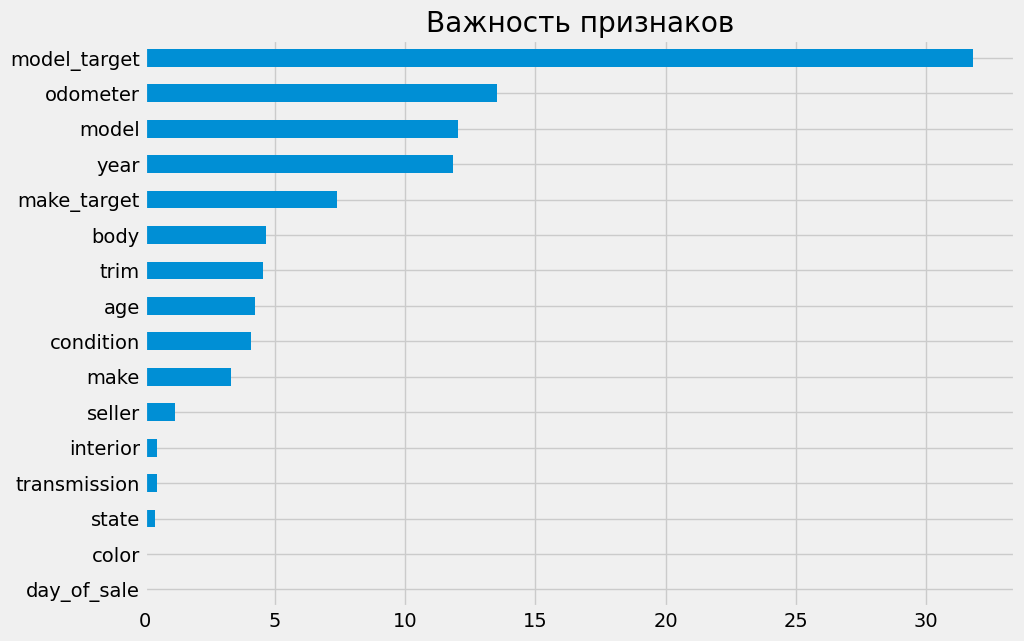

In [142]:
# построим гистограмму значимости признаков для модели CatBoost
# значения отсортированные по возрастанию влияния

plt.figure(figsize = (10,7))
importances = pd.Series(best_model_cb.named_steps['cb'].feature_importances_,index=best_model_cb['cb'].feature_names_).sort_values()

# график
importances.plot.barh(grid=True, title='Важность признаков');

**LGBMRegressor**

In [143]:
# обозначим категориальные столбцы для передачи в LGBMRegressor
cat_columns = X_train.select_dtypes(include='object').columns.to_list()
cat_columns 

data[cat_columns] = data[cat_columns].astype("category")

In [144]:
# cоздадим переменные для признаков и целевого признака
X = data.drop('sellingprice', axis=1)
y = data['sellingprice']

In [145]:
# выведем на экран размеры таблиц, которые хранятся в 2-х переменных
X.shape,y.shape

((440236, 16), (440236,))

In [146]:
# обозначим категориальные столбцы теста для передачи в LGBMRegressor
cat_features_test = X_test.select_dtypes(include='object').columns.to_list()
test[cat_columns] = test[cat_features_test].astype("category")

In [147]:
X_test = test.drop('vin', axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   year          110058 non-null  int64   
 1   make          110058 non-null  category
 2   model         110058 non-null  category
 3   trim          110058 non-null  category
 4   body          110058 non-null  category
 5   transmission  110058 non-null  category
 6   state         110058 non-null  category
 7   condition     110058 non-null  float64 
 8   odometer      110058 non-null  float64 
 9   color         110058 non-null  category
 10  interior      110058 non-null  category
 11  seller        110058 non-null  category
 12  age           110058 non-null  int64   
 13  day_of_sale   110058 non-null  int64   
 14  make_target   110058 non-null  int64   
 15  model_target  110058 non-null  int64   
dtypes: category(9), float64(2), int64(5)
memory usage: 7.5 MB


In [ ]:
#X_train, X_valid, y_train, y_valid = train_test_split(
    #X,y, test_size=0.25, random_state=RANDOM_STATE)


In [ ]:
# выведем на экран размеры таблиц, которые хранятся в 4-х переменных
#X_train.shape,y_train.shape,X_valid.shape,y_valid.shape

In [ ]:
# инициализируем модель LGBMRegressor
#lgbm = LGBMRegressor(objective='RMSE',random_state=RANDOM_STATE)

In [ ]:
#lgbm.fit(X_train, y_train)

In [ ]:
#predictions_lgbm = lgbm.predict(X_valid)
#mape_score = mape(y_valid, predictions_lgbm)
#print('MAPE:', mape_score)

In [ ]:
# построим гистограмму значимости признаков для модели LGBMRegressor
# значения отсортированные по возрастанию влияния

#plt.figure(figsize = (10,7))
#importances = pd.Series(lgbm.feature_importances_,index=X_train.columns).sort_values()

# график
#importances.plot.barh(grid=True, title='Важность признаков LGBMRegressor');

**LGBMRegressor** с подбором гиперпараметров и кросс-валидацией

In [148]:
pipeline_lightgbm = Pipeline([
    ('lgbm', LGBMRegressor(random_state=RANDOM_STATE,force_row_wise=True))
                          
])

parameters_lightgbm = {
    'lgbm__n_estimators': [1000],
    'lgbm__max_depth': [12],
    'lgbm__learning_rate': [0.01,0.1,0.15],
    'lgbm__num_leaves': [24,36],
    'lgbm__reg_alpha': [0, 0.1, 0.5]
}

gs_model_lightgbm = GridSearchCV(
    estimator=pipeline_lightgbm,
    param_grid=parameters_lightgbm,
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,error_score='raise'
)

In [149]:
gs_model_lightgbm.fit(X,y)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Total Bins 6974
[LightGBM] [Info] Number of data points in the train set: 440236, number of used features: 16
[LightGBM] [Info] Start training from score 13592.209588


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('lgbm',
                                        LGBMRegressor(force_row_wise=True,
                                                      random_state=12345))]),
             n_jobs=-1,
             param_grid={'lgbm__learning_rate': [0.01, 0.1, 0.15],
                         'lgbm__max_depth': [12], 'lgbm__n_estimators': [1000],
                         'lgbm__num_leaves': [24, 36],
                         'lgbm__reg_alpha': [0, 0.1, 0.5]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [150]:
best_params_lightgbm = gs_model_lightgbm.best_params_
best_params_lightgbm

{'lgbm__learning_rate': 0.1,
 'lgbm__max_depth': 12,
 'lgbm__n_estimators': 1000,
 'lgbm__num_leaves': 36,
 'lgbm__reg_alpha': 0.1}

In [151]:
best_model_lightgbm = gs_model_lightgbm.best_estimator_
best_model_lightgbm

Pipeline(steps=[('lgbm',
                 LGBMRegressor(force_row_wise=True, max_depth=12,
                               n_estimators=1000, num_leaves=36,
                               random_state=12345, reg_alpha=0.1))])

In [152]:
best_score_lightgbm = -gs_model_lightgbm.best_score_

print(f'Лучшее MAPE для LGBMRegressor на кросс-валидации: {best_score_lightgbm}')

Лучшее MAPE для LGBMRegressor на кросс-валидации: 0.15381110999386052


In [154]:
result = pd.DataFrame(
    [dummy_model_mape,best_score_lr, best_score_rf,mape_score_cb,best_score_lightgbm], 
    index = ['DummyRegressor','LinearRegression', 'RandomForestRegressor','CatBoostRegressor','LGBMRegressor'], 
    columns = ['MAPE']
)
result

,MAPE
DummyRegressor,1.873461
LinearRegression,0.783177
RandomForestRegressor,0.276193
CatBoostRegressor,0.210782
LGBMRegressor,0.153811


### Тестирование лучшей модели на тестовой выборке и получение предсказаний для submit на Kaggle

In [155]:
best_submission_lightgbm  = pd.DataFrame()
best_submission_lightgbm ['vin'] = test['vin']
# делаем предсказания на тестовых данных
best_submission_lightgbm ['sellingprice'] = best_model_lightgbm.predict(X_test)

In [156]:
output = pd.DataFrame(best_submission_lightgbm)
output.to_csv('submission.csv',index=False)

In [157]:
# сравним с образцом сабмита
sample_submission_ex = pd.read_csv('sample_submission.csv')
sample_submission_ex.head()

,vin,sellingprice
0,1g6dp567450124779,13592.209588
1,1gtw7fca7e1902207,13592.209588
2,jn8az1mw6dw303497,13592.209588
3,2g1wf5e34d1160703,13592.209588
4,1n6aa0ec3dn301209,13592.209588


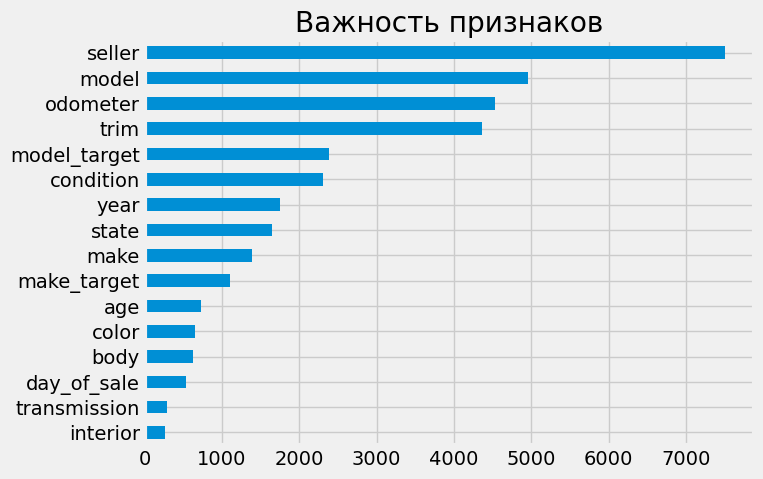

In [160]:
# построим гистограмму значимости признаков для модели lightgbm
# значения отсортированные по возрастанию влияния

plt.figure(figsize = (7,5))
importances = pd.Series(best_model_lightgbm.named_steps['lgbm'].feature_importances_,index=X.columns).sort_values()

# график
importances.plot.barh(grid=True, title='Важность признаков');

**Используя возможности библиотеки Shap построим графики**

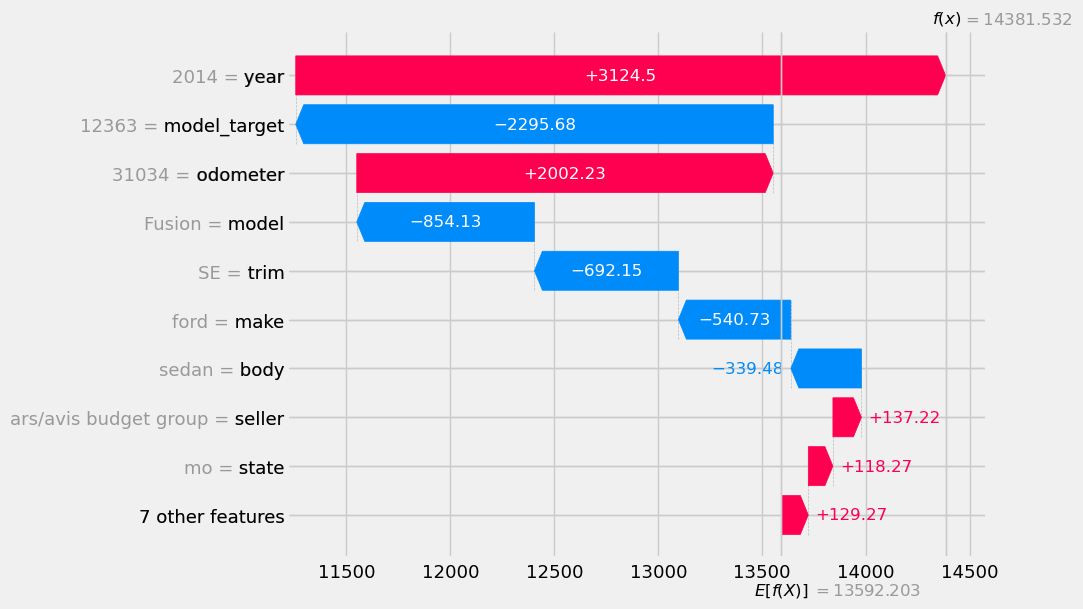

In [161]:
explainer = shap.Explainer(best_model_lightgbm.named_steps['lgbm'])
shap_values = explainer(X)

# визуализируем вклад каждого признака,например, во втором наблюдении
shap.plots.waterfall(shap_values[1])

График waterfall из библиотеки SHAP предназначен для визуализации влияния каждого признака на предсказание модели для конкретного наблюдения данных.

На графике каждая горизонтальная полоска представляет собой признак, который вносит свой вклад в предсказание модели. Высота полоски показывает абсолютное значение вклада, а цвет указывает на положительную (красный) или отрицательную (синий) ориентацию вклада.

Начальное значение предсказания модели отображается в верхней части графика, а каждый следующий признак добавляется сверху вниз, изменяя предсказание. Вклад каждого признака накапливается в общий вклад, поэтому высота полоски представляет собой сумму вкладов всех предыдущих признаков.

Mетрика MAPE у дамми модели гораздо выше, чем на всех наших моделях на тестовой выборке. Это говорит нам о том, что наши модели достаточно адекватны.

**При загрузке на Kaggle получили следующий результат:**

Score: 14.15129
Public score: 14.06810  

## Общий вывод
### Вывод

Мы провели работу по подготовке прототипа модели машинного обучения. Данная работа принимала участие в соревновании на платформе Kaggle.

**Цель проекта** - прогнозирование стоимости автомобилей на вторичном рынке.

**Наша задача** - создание прототипа модели машинного обучения, который позволит позволит компаниям разрабатывать собственное приложение, чтобы привлечь новых клиентов для оценки стоимости их авто для продажи. 

Для оценки качества моделей была использована метрика MAPE (Mean Absolute Percentage Error),которая измеряет отклонение прогнозных значений от фактических значений в процентном соотношении.

В нашем распоряжении были исторические данные о технических характеристиках,марках,моделях, комплектации, состоянии и ценах других автомобилей. Данные находились в 2-х файлах (обучающая и тестовые датасеты). В ходе работы был проведен обзор первоначальных данных и их предобработка. Найденные пропуски были заполнены соответствующими значениями или заглушкой '-'. Дубликаты обработаны. Неинформативные столбцы были удалены, т.к. не представляют важности при обучении модели. Аномалии в данных изучены.

Работа была проведена в соответствии с первононачальным планом. Возникли некоторые сложности с кодированием признаков для модели линейной регрессии (не хватило мощности для кодировки), поэтому был использован OrdinalEncoder, вместо OneHotEncoder.

Была проведена загрузка исходных данных, их обзор и предобработка:

1. Изменены типы данных в столбце 'saledate'. В результате выяснили, что данные представлены за период c 2014-01-01 01:15:00+00:00 по 2015-07-20 19:30:00+00:00. В тесте c 2014-01-01 01:15:00+00:00 по 2015-07-13 23:30:00+00:00. Машины продавались с понедельника по пятницу и в воскресенье включительно. В субботу продажи отсутствовали.
2. Удалось заполнить пропущенные значения в столбце 'make', получив информацию из vin кода.
3. Пропуски в столбце 'transmission' заполнили на основе группировки по году, марке, модели авто и получению методом idmax наиболее вероятного значения. Оставшиеся 0,4 % пропусков были заполнены заглушкой '-'. В тесте пропуски заполнены аналогично трейну, значениями из трейна.

4. Пропуски в столбце transmission заполнили на основе группировки по году, марке, модели авто и получению методом idmax наиболее вероятного значения. Оставшиеся 0,4 % пропусков были заполнены модой на основании группировки столбцов (год, марка, модель) авто. В тесте заменены аналогично трейну.
5. В condition заполнили средним значением, т.к. не знаем, в каком состоянии находится авто на момент аукциона.
6. В odometer заполнили средним значением, на основании группировки по трем столбцам make,model,year; оставшиеся пропуски в датафрейме заполним заглушкой '—', т.к данная заглушка у нас уже встречается в данных, чтобы впоследствии не "путать" модель.
4. Незначительные пропуски (около 2%) в столбцах 'model','trim','body','color','interior' были обработаны в трейне и заполнены средними значениями, модой или заглушкой '-'. В тесте пропуски заполнены аналогично трейну, значениями из трейна.
5. Поработали с неявными дубликатами в столбцах 'make'и'body'. Путем приведения к нижнему регистру удалось снизить количество дубликатов только в столбце 'body'.
6. Посмотрели столбец с пробегом, выявили 55 строк с аномально большим пробегом, оставили без изменений.
7. Столбец 'vin' удалили из трейна т.к. он для нас не важен. В тесте оставили.
8. После изучения всех признаков мы получили обучающий датасет размером (440236, 17) и тестовый (110058, 17);

Далее мы провели глубокий исследовательский анализ данных и визуализировали с помощью графиков результаты зависимости наших признаков и таргета:

* в среднем автомобили продаются за 13592 ед. 
* из столбца saledate мы создали новый признак - год продажи авто;
* создали новый признак - возраст авто;
* попробовали создать новый признак - пробег за год(`run_per_year`);
* также применили target encoding и создали 2 новый признака:
 на основе средней цены продажи (sellingprice) для каждого уникального значения в столбце make:`make_target`;
 на основе средней цены продажи (sellingprice) для каждого уникального значения в столбце model:`model_target`;
* обнаружили 166 авто 2015 г. проданных в 2014 г.;
* увидели среднюю корреляцию между числовыми данными и нашим таргетом. Наибольший интерес заслуживает наличие отрицательной взаимосвязи между пробегом и стоимостью при продаже (-0,78), что логично, ведь чем больше пробег у авто, тем ниже ее цена. Также есть корреляция (0,55) между состоянием авто и ценой, и между годом регистрации и ценой(0,58).
* удалены столбцы `vin`,`saledate`;
* при изучении тепловой карты корреляции, а также при дальнейших экспериментах при обучении моделей, принято решение удалить созданные признаки run_per_year,year_of_sale из-за слабой корреляции с таргетом и отсутствия влияния данных признаков на метрику;
* после изучения и удаления неинформативных признаков мы получили обучающий датасет размером (440236, 17) и тестовый (110058, 17); 



Следующим шагом была подготовка данных для обучения моделей, в частности был введен параметр RANDOM_STATE = 12345.

Нами было инициализировано 5 моделей: Lasso,LinearRegression, RandomForestRegressor, CatBoostRegressor и LGBMRegressor. Для подбора гиперпараметров в целях улучшения качества моделей, а также для проведения проверки качества был использован GridSearchCV.

При обучении модели CatBoostRegressor без подбора гиперпараметров и кросс-валидации была проведена разбивка данных на обучающий и валидационный набор, с размером валидационной выборки 0.25.

Для моделей Lasso,LinearRegression, RandomForestRegressor было проведено кодирование категориальных признаков методом OrdinalEncoder (для линейных моделей следовало бы использовать при кодировке OneHotEncoder, но для данного датасета не хватило мощности для обработки) и масштабирование численных признаков методом стандартизации StandardScaler. 

Для CatBoostRegressor и LGBMRegressor обозначили категориальные и численные признаки для дальнейшего обучения моделей.

**Так для обучения модели были использованы следующие 16 признаков:**

категориальные:'make,'model','trim','body','transmission','state','color','interior','seller';    
численные 'year', 'condition', 'odometer','age','day_of_sale','make_target','model_target'

Далее мы провели обучение моделей машинного обучения, для выполнения поставленной цели. Ключевой метрикой моделей была использована метрика MAPE (Mean Absolute Percentage Error),которая измеряет отклонение прогнозных значений от фактических значений в процентном соотношении.

В самом начале обучили Baseline модель, которая дала метрику MAPE 1.87.
Метрика MAPE для модели LinearRegression показала очень слабый результат (0,78). Для RandomForestRegressor составила 0,27.

Наилучшие результаты были достигнуты при ипользовании бустинговых моделей.
Выбрав лучшую модель LGBMRegressor, которая достигла самого низкого значения MAPE на кросс-валидации (0.1538),мы получили с помощью нее предсказания для нашей тестовой выборки и отправили на 'submit'. 

При загрузке на Kaggle получили следующий результат:
Score: 14.15129
Public score: 14.06810  

Также мы рассмотрели наиболее значимые признаки, которые позволили достигнуть нашей метрики. Можем выделить следующие наиболее **важные признаки при обучении модели**,в порядке важности:

seller          
model           
odometer        
trim            
model_target    
condition       
year            
state          
make            
make_target     
age              
color            
body             
day_of_sale      
transmission
interior;            

Лучшей моделью машинного обучения в нашем случае выбрана модель LGBMRegressor, показав лучшее значение на тестовых данных значение 14.1512 (на обучающей 15,3811).

**Гиперпараметры итоговой лучшей модели:**

**LGBMRegressor**

(random_state=RANDOM_STATE,    
'lgbm__learning_rate': 0.1,    
'lgbm__max_depth': 12,    
'lgbm__n_estimators': 1000,    
'lgbm__num_leaves': 36,    
'lgbm__reg_alpha': 0.1).   

